Step 1 : Importing the required libraries

In [12]:
#import required libraries
import os
import cv2 , math
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt


Step 2 : Routing the path of the dataset

In [13]:
from pathlib import Path

# use current working directory
base_dir = Path.cwd()
data_dir = base_dir / "Dataset"

print(f"Data directory: {data_dir}")

categories = ["Number_1", "Number_2", "Number_3","Number_4","Number_5","Number_6","Number_7","Number_8","Number_9","Symbol_Draw_2","Symbol_Reverse","Symbol_Skip"]
img_size = 224

Data directory: C:\Users\vigne\Desktop\CW2_PDE4434_Intelligent_Sensing\CW2_PDE4434_Intelligent_Sensing\Dataset


Step 3 : Loading the dataset and preprocessing

In [27]:
def load_data():
    data = []
    labels = []
    for category in categories:
        path = os.path.join(data_dir, category)
        label = categories.index(category)  
        for img in os.listdir(path):
            try:
                img_path = os.path.join(path, img)
                img_input = cv2.imread(img_path, cv2.IMREAD_COLOR)

                #copying the origianl image
                copy_image=img_input.copy()

                #preprocessing cycle -1 :
                gray = cv2.cvtColor(img_input, cv2.COLOR_BGR2GRAY)#converting to gray scale
                _, thresh = cv2.threshold(gray,200, 255, cv2.THRESH_BINARY) #thresholding the image
                edges = cv2.Canny(thresh, 100, 200)# edge detection

                kernel = np.ones((5, 5), np.uint8) #matrix size for dilation and eroding 5 x 5

                dilated = cv2.dilate(edges, kernel, iterations=2) #dilation
                eroded = cv2.erode(dilated, kernel, iterations=1) #erosion
                
                contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE) # finds the contour
                cv2.drawContours(img_input, contours, -1, (0, 255, 0), 3) # draw a contour around the uno card

                for contour in contours:
                    rect = cv2.minAreaRect(contour)

                    box = cv2.boxPoints(rect) # creating the box points
                    box = box.astype(int) # getting the x, y value for each cornor points
                    
                    cv2.drawContours(img_input, [box], -1, (255, 0, 0), 3) # drawing a box

                #calculating the center point
                center_x = int(np.mean(box[:, 0]))
                center_y = int(np.mean(box[:, 1]))

                # Draw the center point
                cv2.circle(img_input, (center_x, center_y), 5, (0, 0, 255), -1)

                pt1, pt2, pt3, pt4 = box #four points of the rectangle

                # midpoint of pt1 - pt2
                mid1 = ((pt1[0] + pt2[0]) // 2, (pt1[1] + pt2[1]) // 2)
                
                # midpoint of pt3 - pt4
                mid2 = ((pt3[0] + pt4[0]) // 2, (pt3[1] + pt4[1]) // 2)
                
                #midpoint of pt1 - pt4
                mid3=((pt1[0] + pt4[0]) // 2, (pt1[1] + pt4[1]) // 2)
                
                #midpoint of pt2 - pt3
                mid4 = ((pt3[0] + pt2[0]) // 2, (pt3[1] + pt2[1]) // 2)

                # Draw the line between midpoints
                cv2.line(img_input, mid1, mid2, (255, 255, 0), 2)  
                cv2.line(img_input, mid3, mid4, (0, 255, 0), 2)
                
                #distance between points or length of the line
                line1_length=math.sqrt((mid2[0] - mid1[0])**2+(mid2[1] - mid1[1])**2)
                line2_length=math.sqrt((mid4[0] - mid3[0])**2+(mid4[1] - mid3[1])**2)

                #finding the longest line and setting those mid point to take angle
                if line1_length>line2_length:
                    midpoint1=mid1
                    midpoint2=mid2
                else:
                    midpoint1=mid3
                    midpoint2=mid4
                    
                # length of reference line
                line_length = 100
                
                # Starting point is center
                start_point = (center_x, center_y)
                
                # End point straight up (90 degrees)
                end_point = (center_x, center_y - line_length)
                
                # Drawing the vertical reference line
                cv2.line(img_input, start_point, end_point, (0, 255, 255), 2)  # Yellow line
                                
                # Vector of midpoint line
                vector_x = midpoint2[0] - midpoint1[0]
                vector_y = midpoint2[1] - midpoint1[1]
                
                # Angle between vector and vertical line (0, -1)
                angle_rad = np.arctan2(vector_y, vector_x) - np.arctan2(-1, 0)
                angle_deg = np.degrees(angle_rad)
                angle_deg = angle_deg % 360 
                                
                # Getting image center
                (h, w) = img_input.shape[:2]
                image_center = (w // 2, h // 2)
                
                # rotation matrix
                M = cv2.getRotationMatrix2D(image_center, angle_deg, 1.0)
                
                # Perform the rotation
                rotated = cv2.warpAffine(copy_image, M, (w, h))
                #show_image(rotated, "Rotated image")
                
                # preprocessing - cycle2

                gray_2 = cv2.cvtColor(rotated, cv2.COLOR_BGR2GRAY) 
                _, thresh_2 = cv2.threshold(gray_2,220, 255, cv2.THRESH_BINARY)             
                edges_2 = cv2.Canny(thresh_2, 100, 200)
                              
                kernel = np.ones((5, 5), np.uint8)
                
                dilated_2 = cv2.dilate(edges_2, kernel, iterations=2)
                eroded_2 = cv2.erode(dilated_2, kernel, iterations=1)
                
                contours, _ = cv2.findContours(eroded_2, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
                
                # Process only if we have at least one valid contour
                for cnt in contours:
                    area = cv2.contourArea(cnt)
                    x, y, w, h = cv2.boundingRect(cnt)
                    cv2.rectangle(rotated, (x, y), (x + w, y + h), (0, 255, 0), 3)
                    
                    
                    if area > 500:  # Filter small areas
                                               
                        cropped = rotated[y:y+h, x:x+w]                       
                        resize_img = cv2.resize(cropped, (224, 224))
                        
                        # preprocessing - cycle3
                        
                        gray_3 = cv2.cvtColor(resize_img, cv2.COLOR_BGR2GRAY)                       
                        _, thresh_3 = cv2.threshold(gray_3,220, 255, cv2.THRESH_BINARY)
                        edges_3 = cv2.Canny(thresh_3, 100, 200)
                        
                        kernel = np.ones((5, 5), np.uint8)
                        
                        dilated_3 = cv2.dilate(edges_3, kernel, iterations=2)
                        eroded_3 = cv2.erode(dilated_3, kernel, iterations=1)
                        
                        contours, _ = cv2.findContours(thresh_3, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
            
                        for cnt in contours:
                            area2 = cv2.contourArea(cnt)
                            
                            
                            if area2> 19000 and area2 <30000:
                                                    
                                background = np.ones((224, 224, 3), dtype=np.uint8) * 255  
                                
                                # Creating mask for the oval contour
                                mask = np.zeros_like(resize_img)
                                cv2.drawContours(mask, [cnt], 0, (255, 255, 255), -1)
                                                               
                                # Applying mask to extract oval region
                                masked = cv2.bitwise_and(resize_img, mask)
                                
                                # Crop the contour region
                                x, y, w, h = cv2.boundingRect(cnt)
                                cropped = masked[y:y+h, x:x+w]
                                
                                # Get shape of cropped region
                                ch, cw = cropped.shape[:2]
                
                                target_size = 224
                                # Compute offsets to center it
                                x_offset = (target_size - cw) // 2
                                y_offset = (target_size - ch) // 2
                                
                                # Pasting cropped oval into the center of white background
                                background[y_offset:y_offset+ch, x_offset:x_offset+cw] = cropped
                
                                #final_crop=cv2.cvtColor(background, cv2.COLOR_BGR2RGB)
                                gray_final = cv2.cvtColor(background, cv2.COLOR_BGR2GRAY)
                                _, thresh_final = cv2.threshold(gray_final,226, 255, cv2.THRESH_BINARY)
                                show_image(thresh_final,"final - image",cmap="grey")
                                
                                data.append(thresh_final)
                                labels.append(label)
                            
            except Exception as e:
                print(f"Error loading image: {e}")
    return np.array(data), np.array(labels)                            

Step 4 : Loading the data and reshaping to prepare for training process

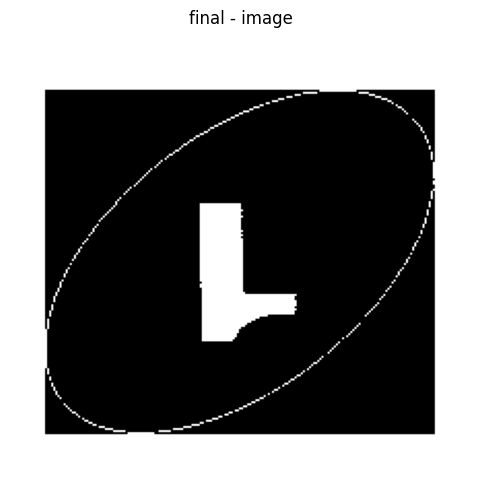

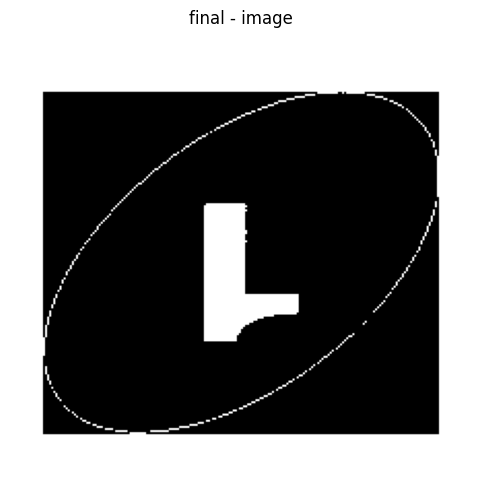

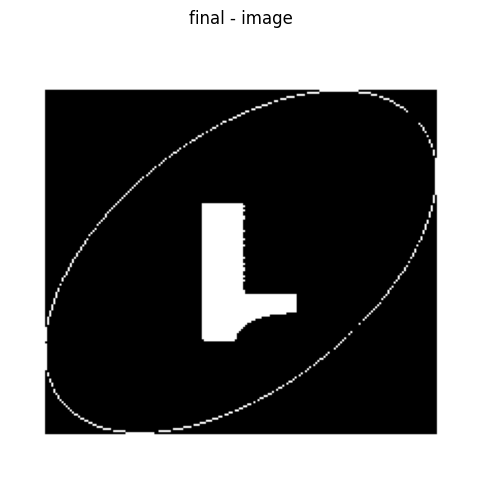

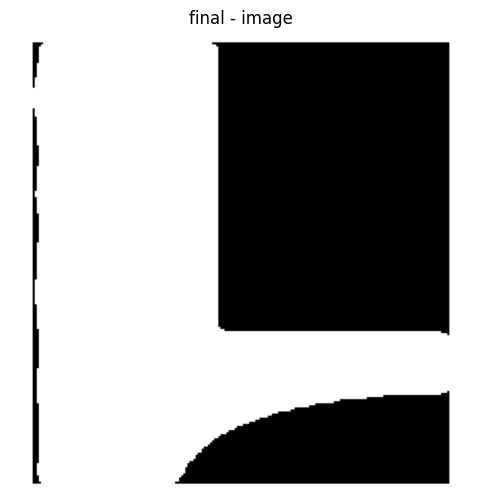

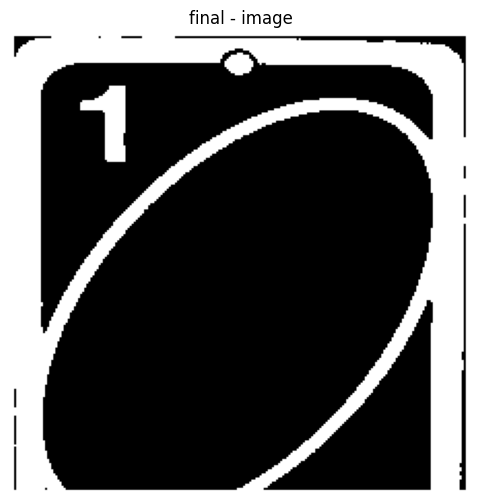

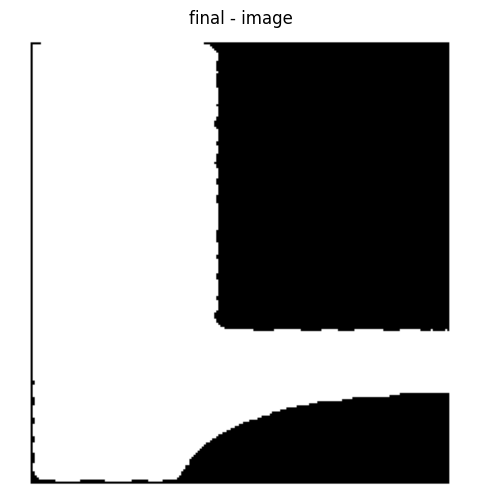

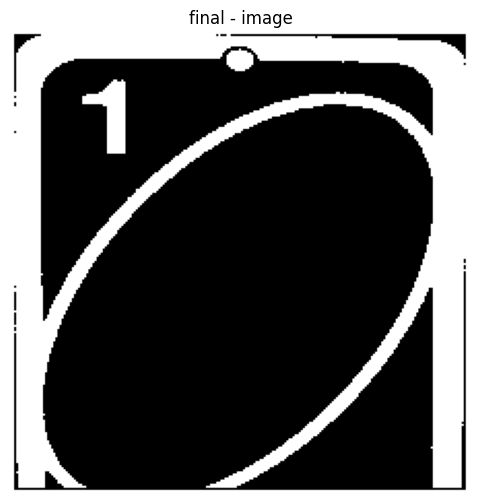

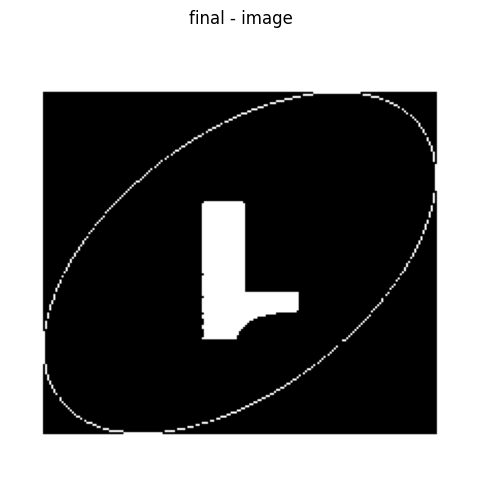

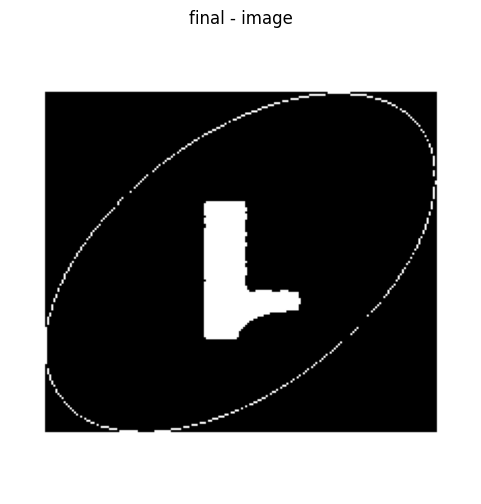

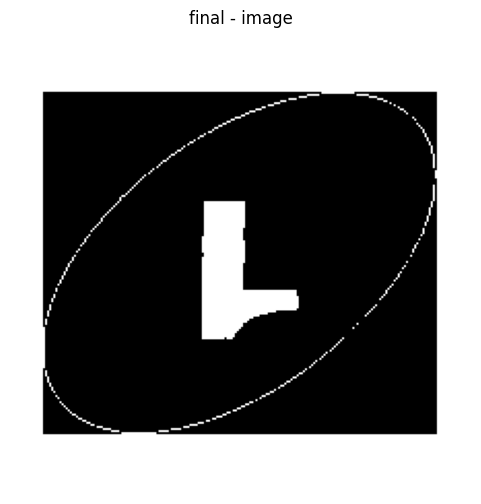

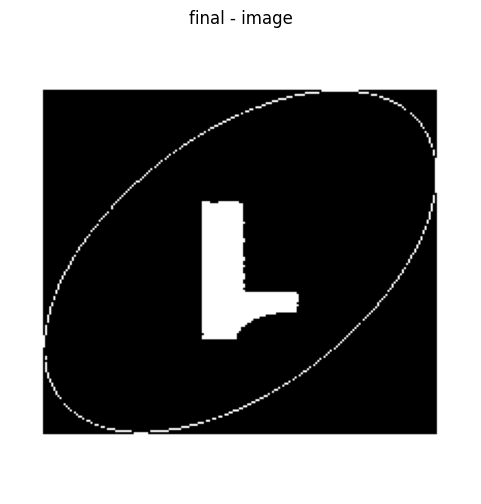

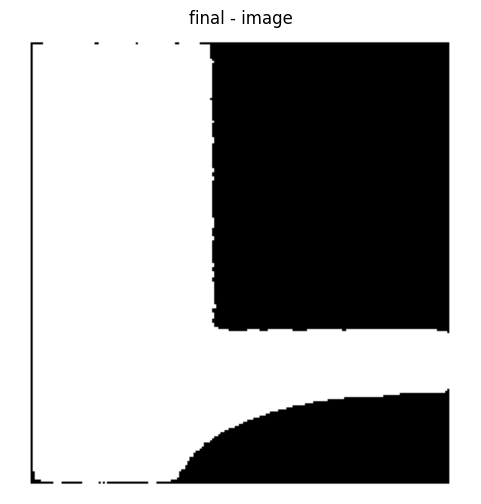

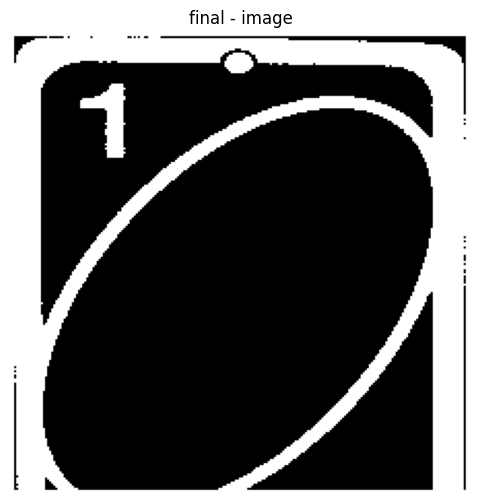

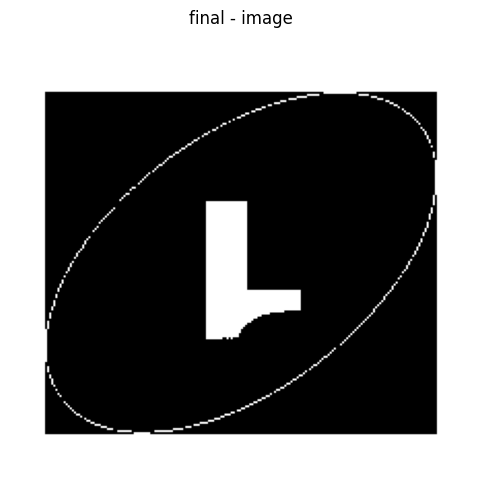

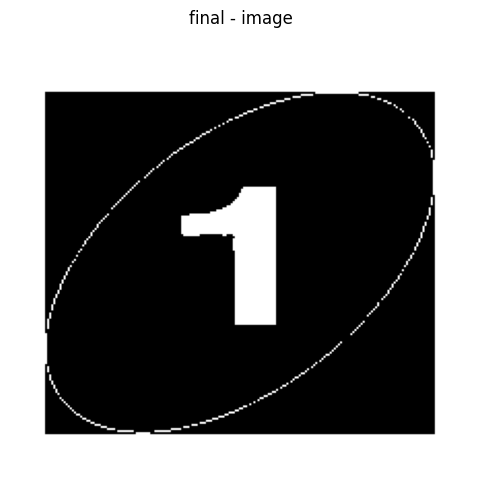

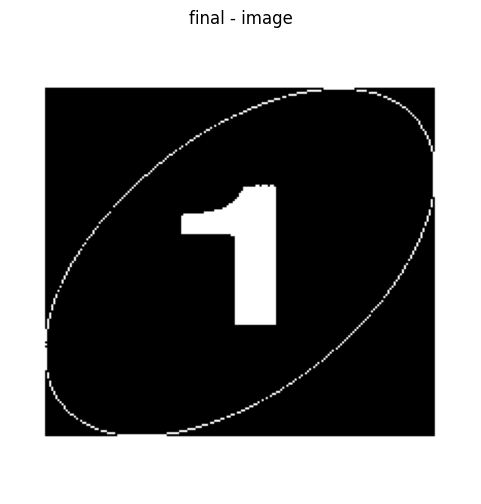

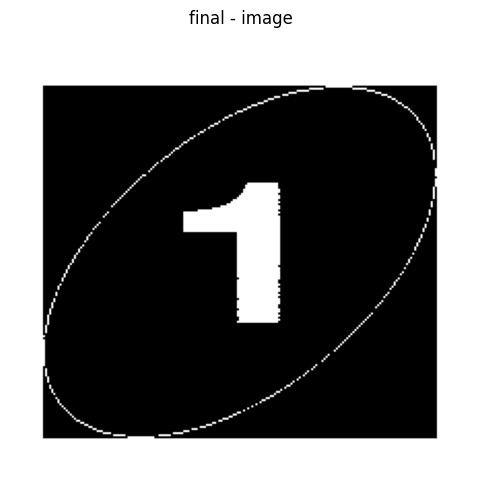

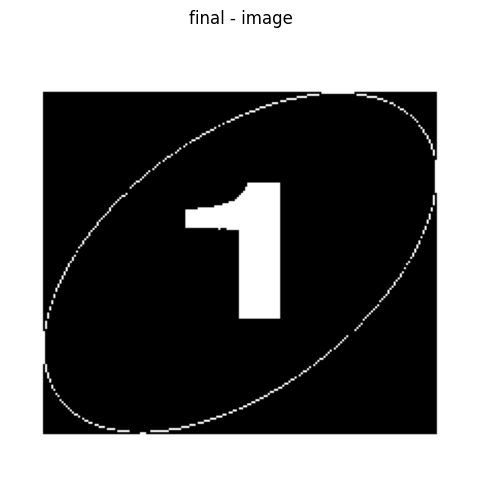

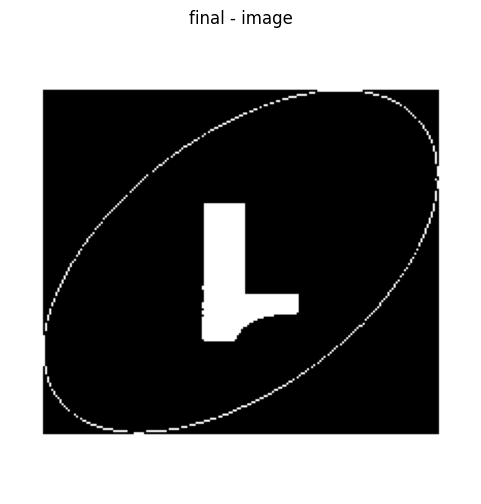

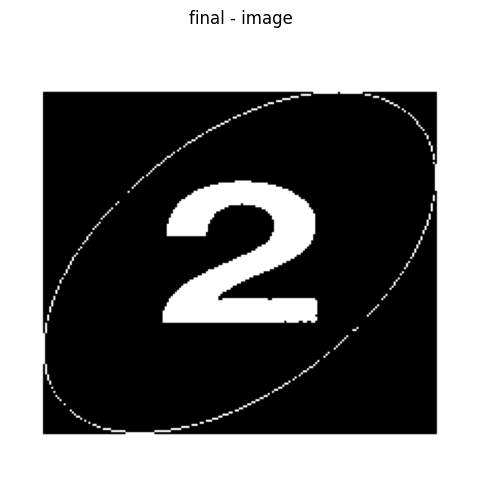

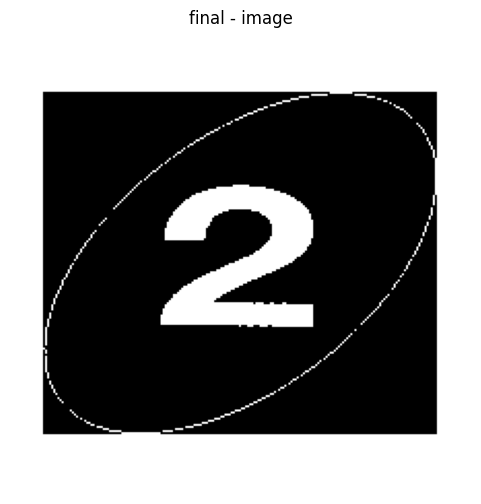

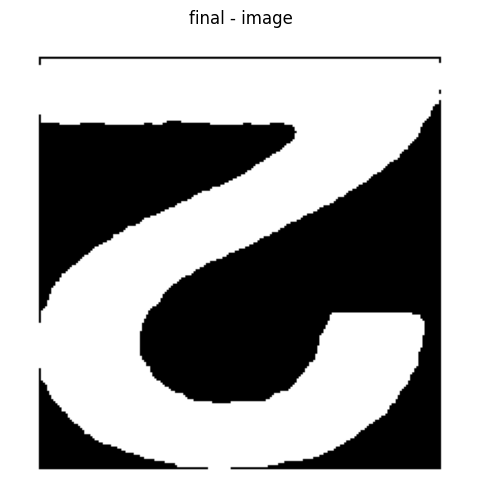

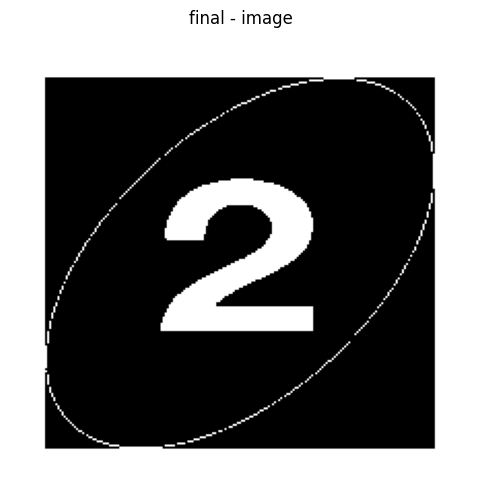

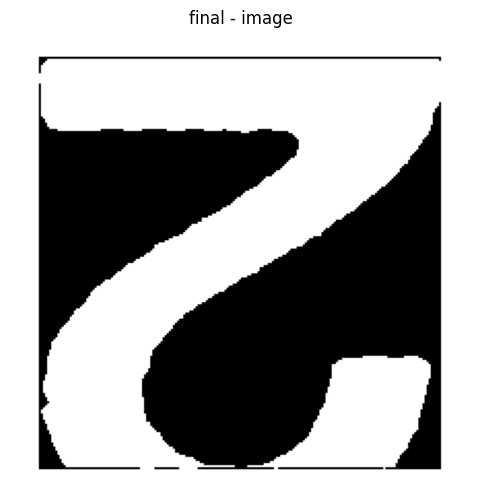

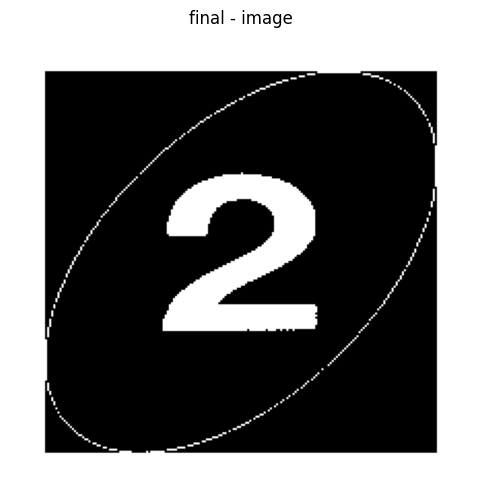

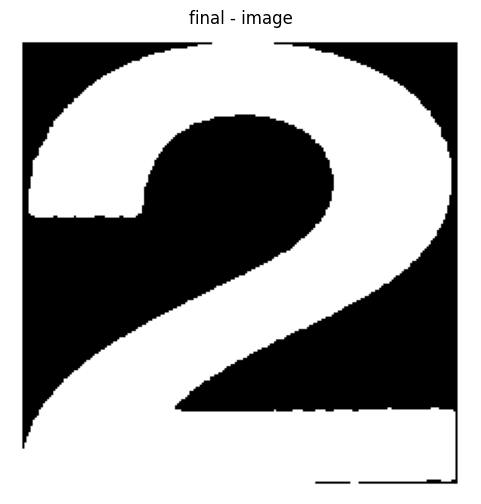

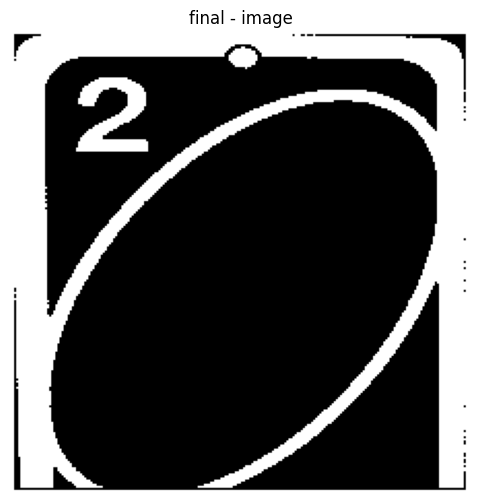

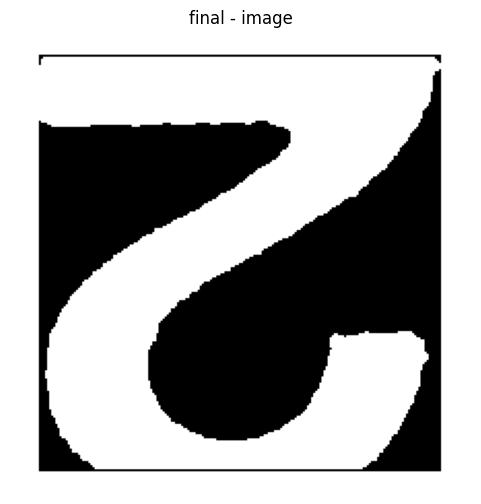

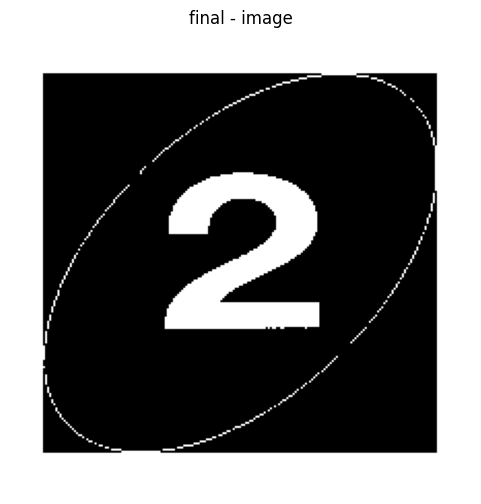

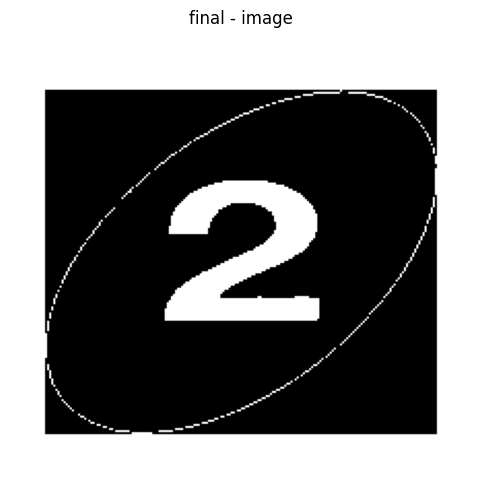

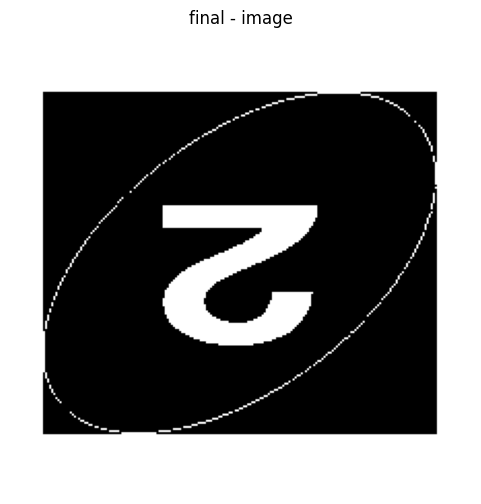

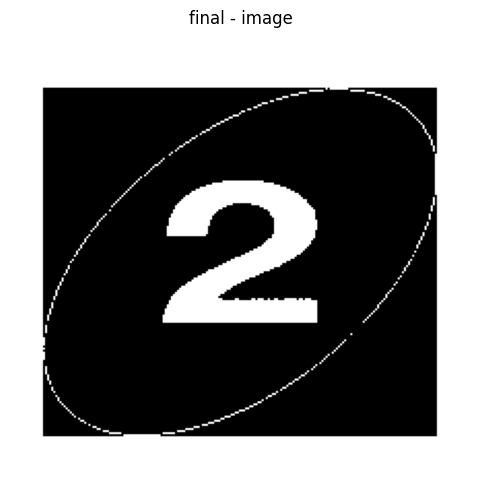

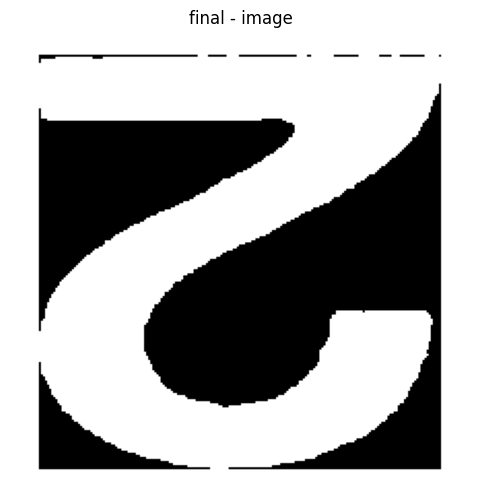

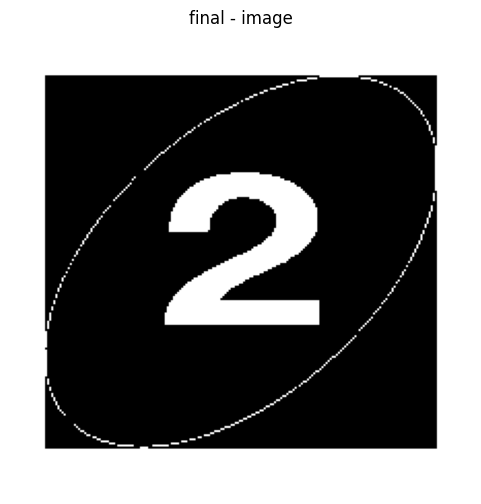

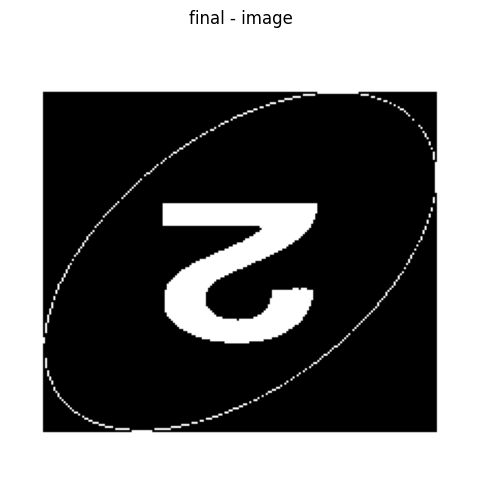

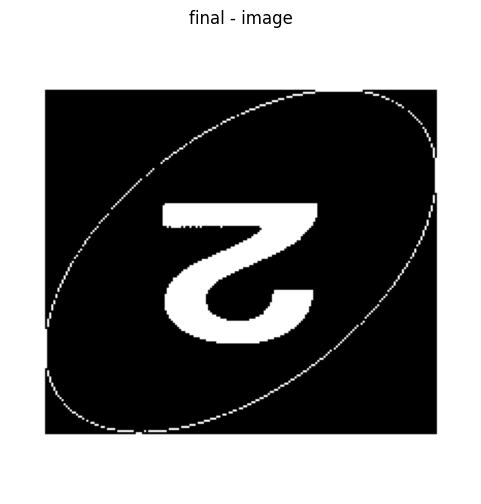

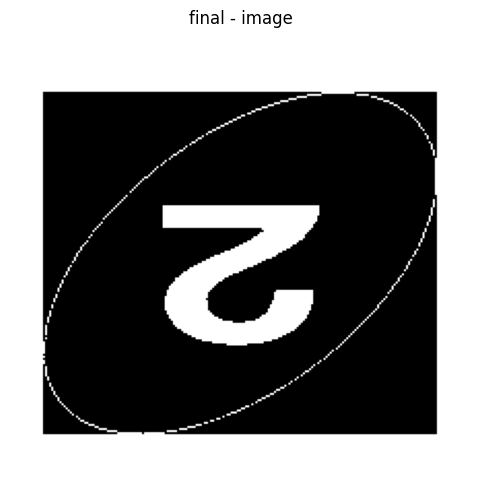

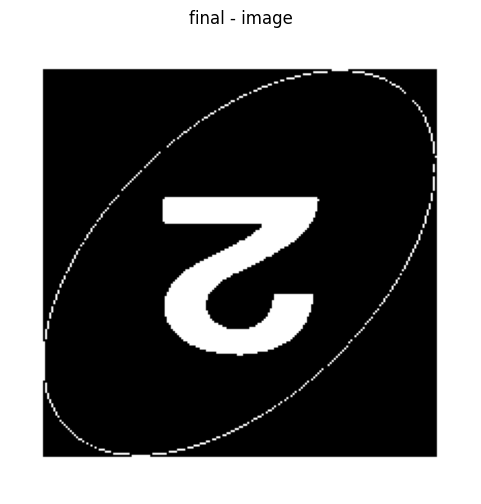

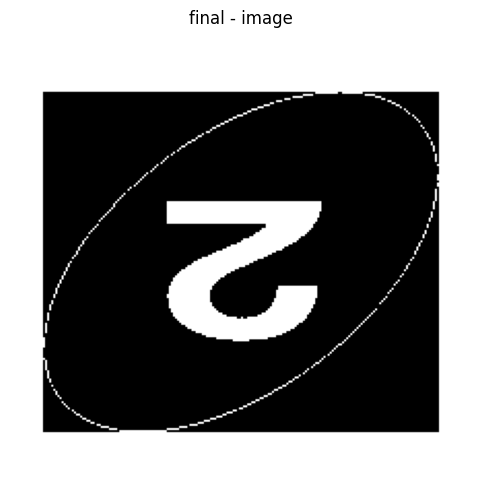

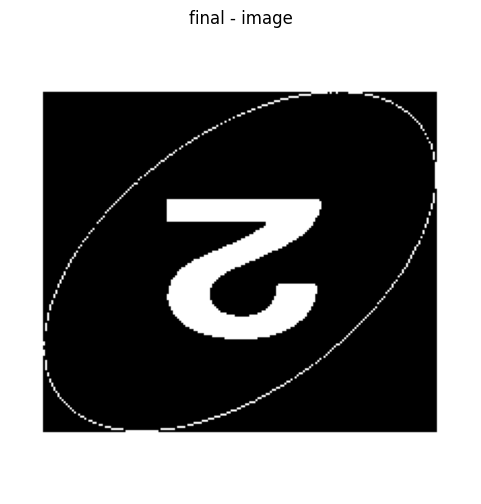

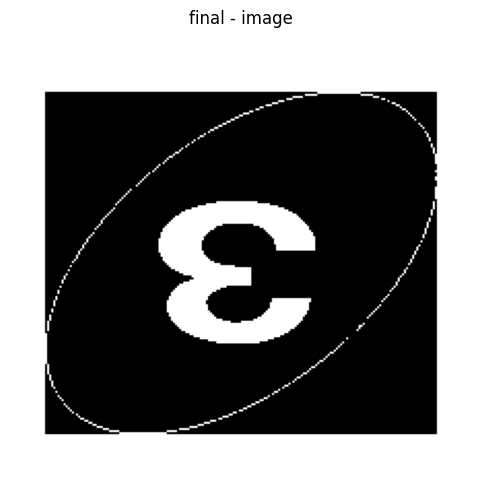

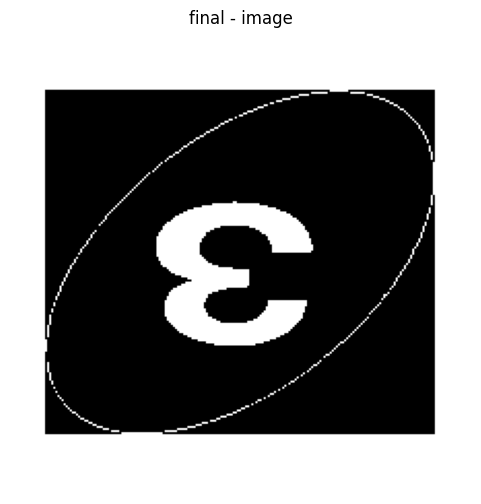

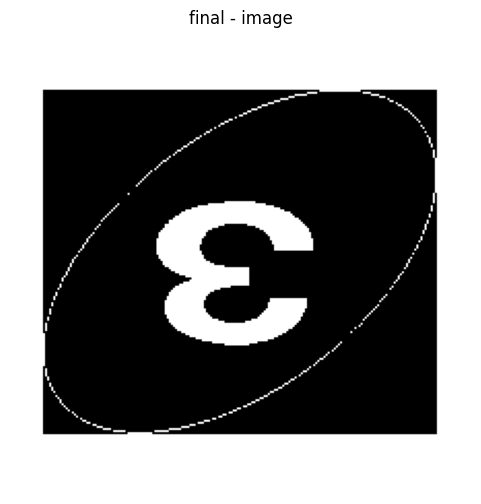

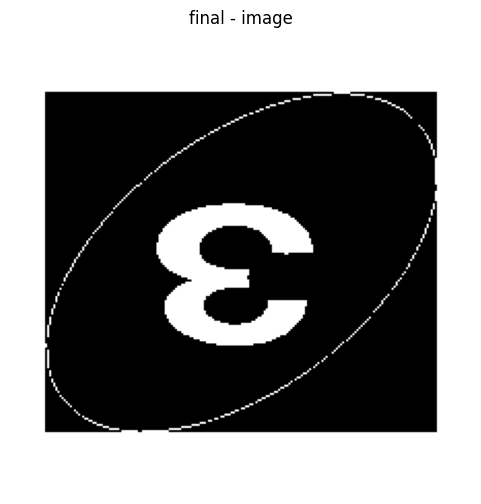

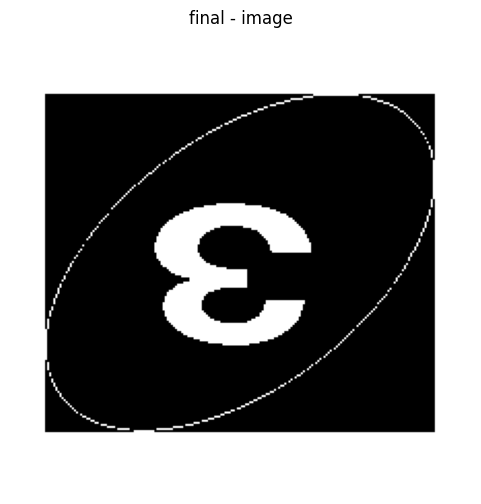

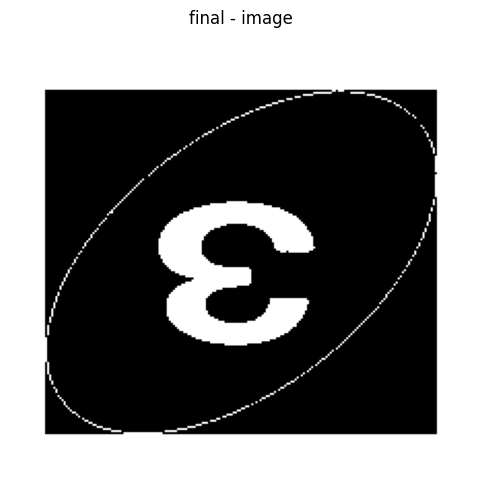

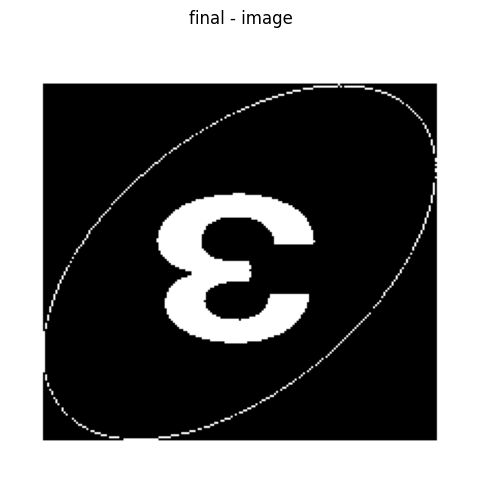

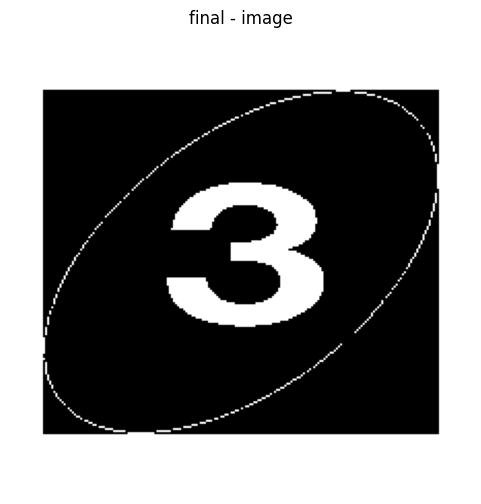

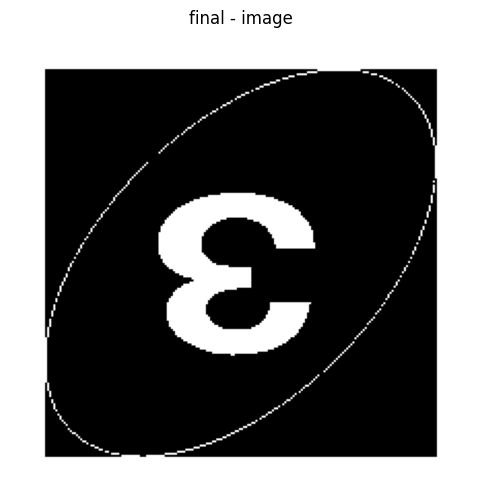

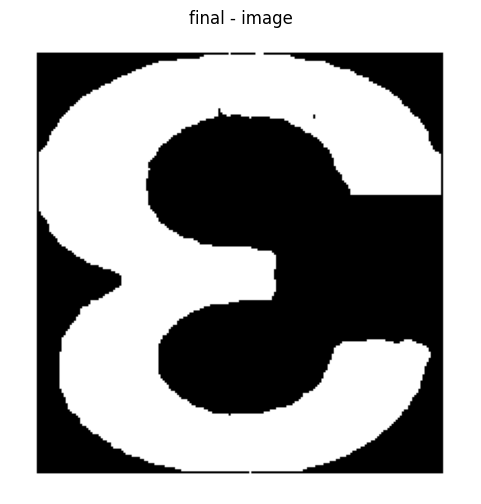

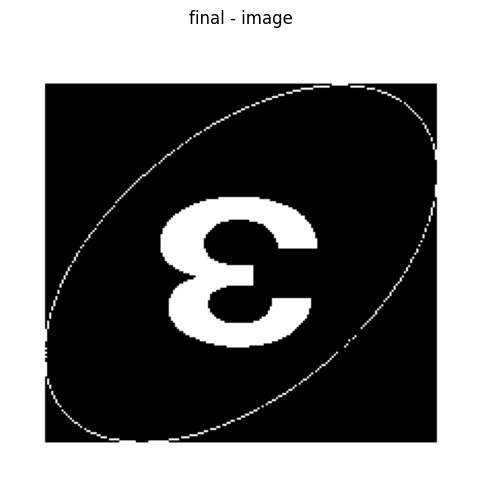

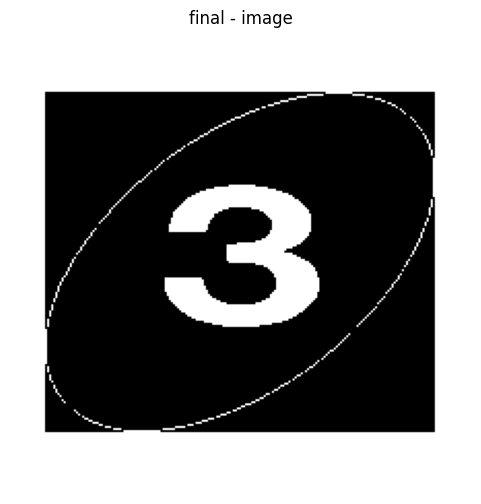

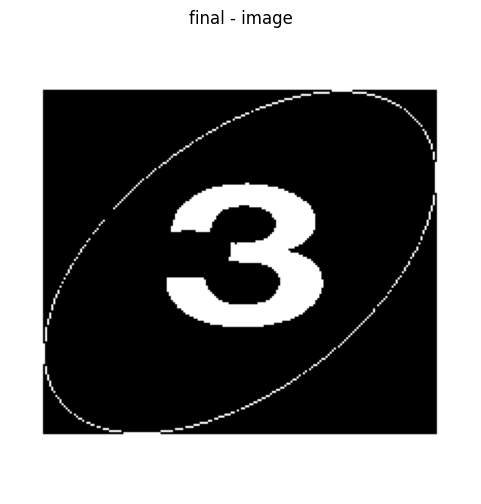

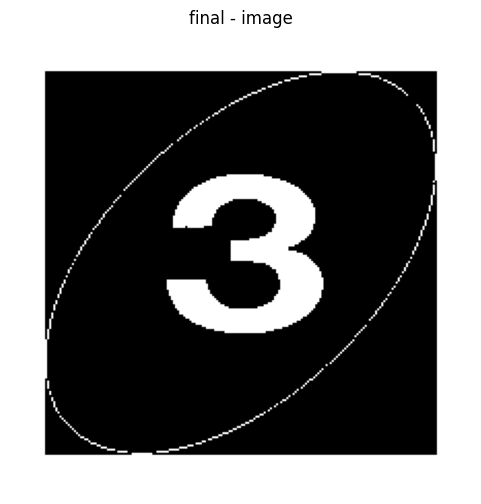

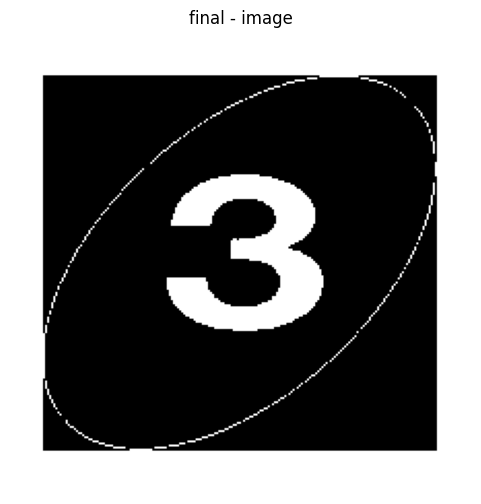

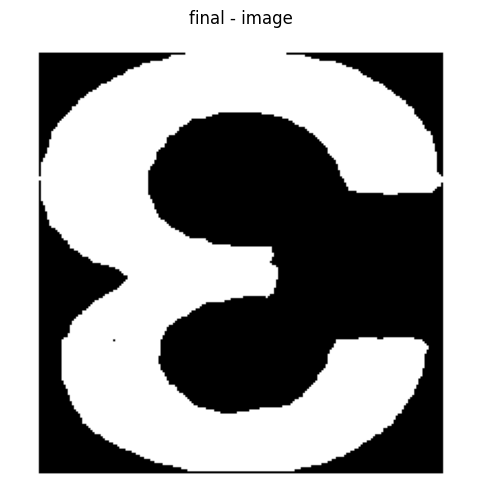

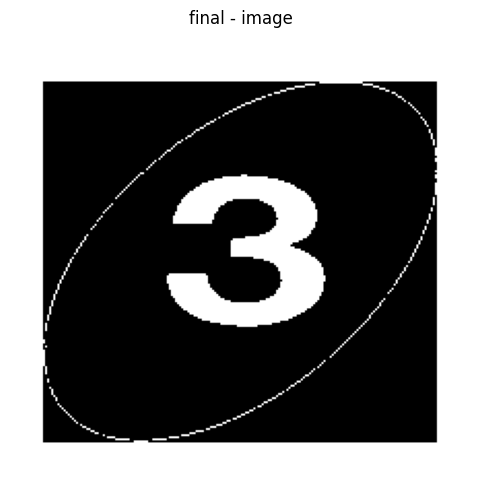

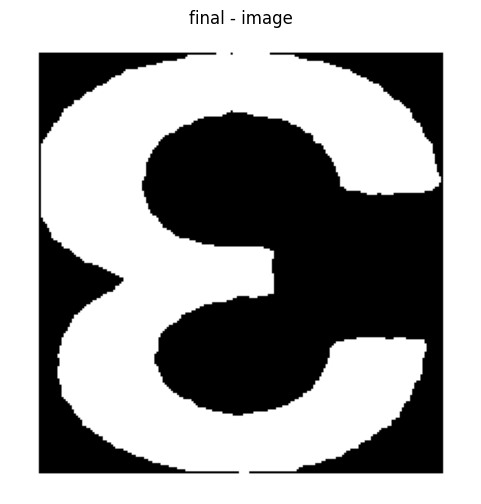

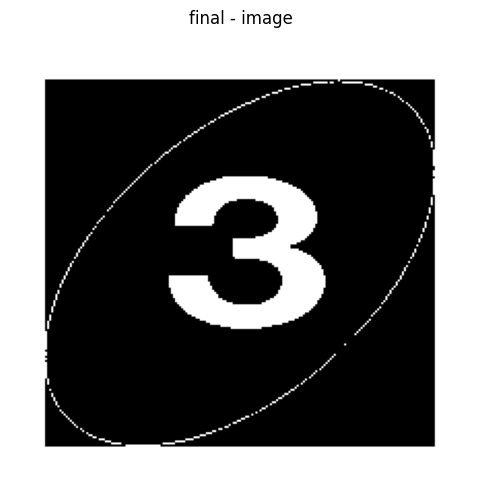

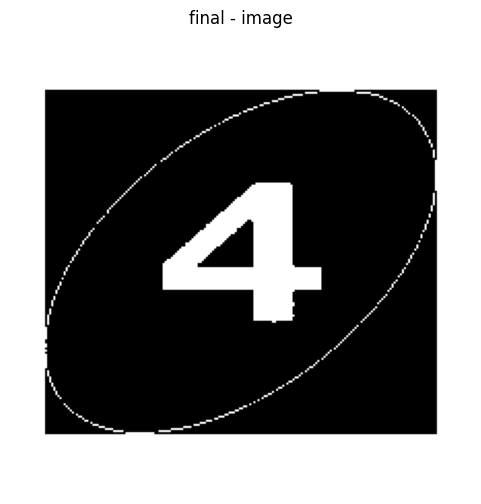

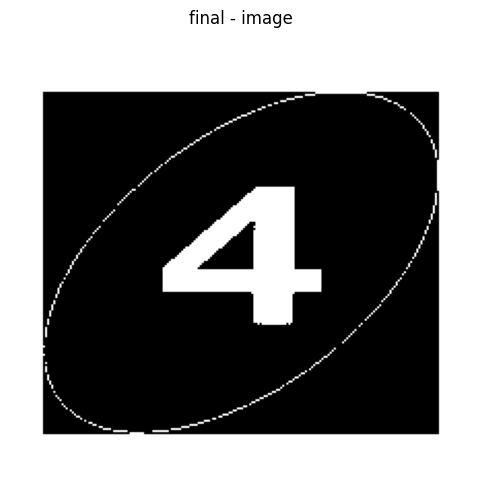

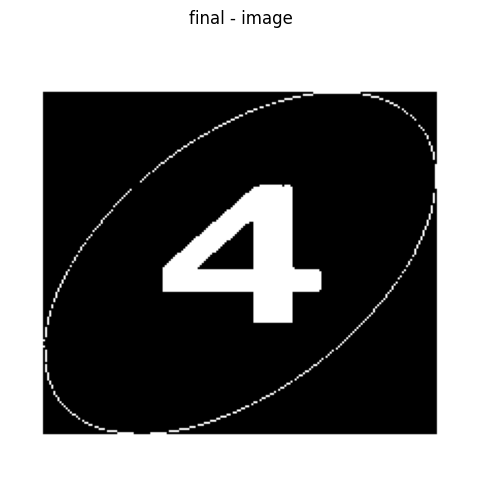

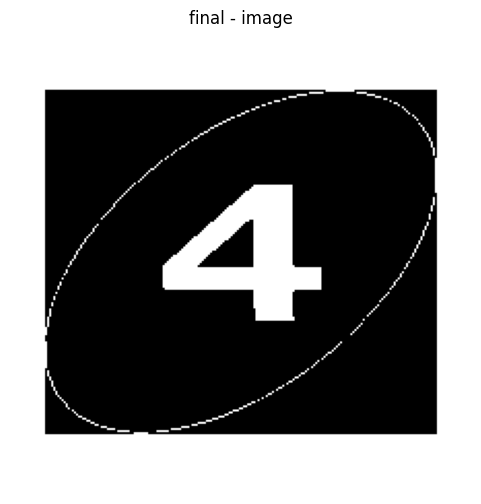

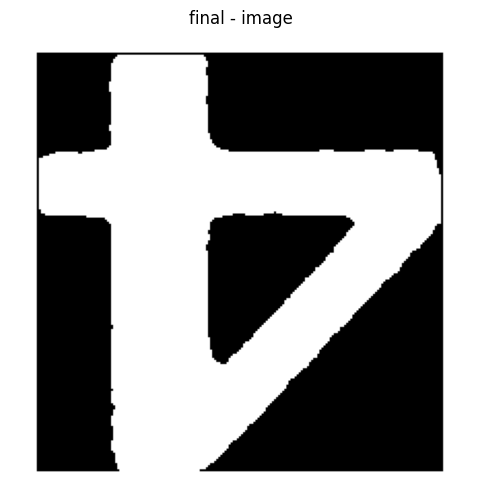

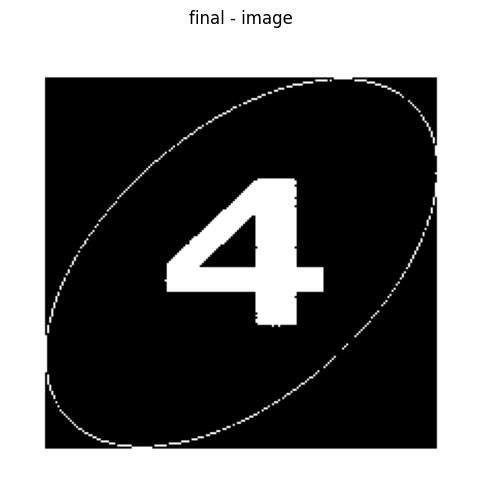

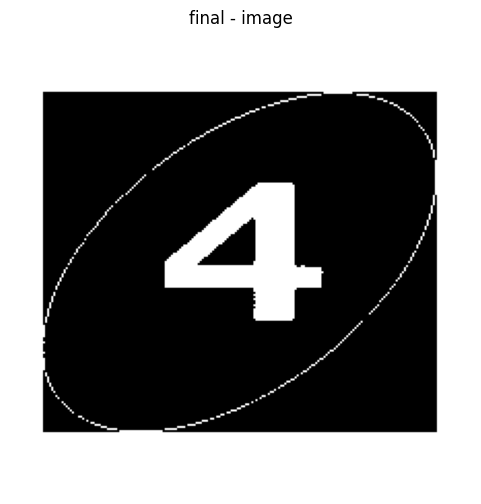

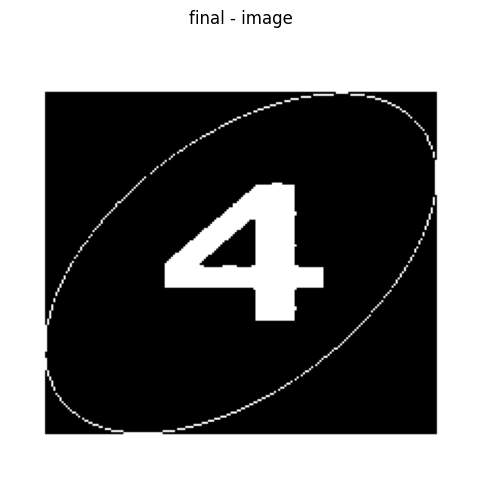

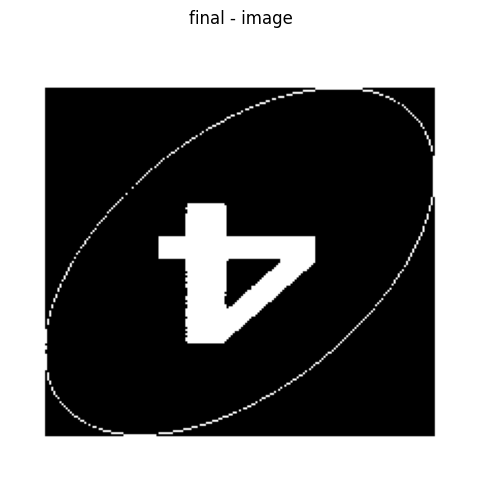

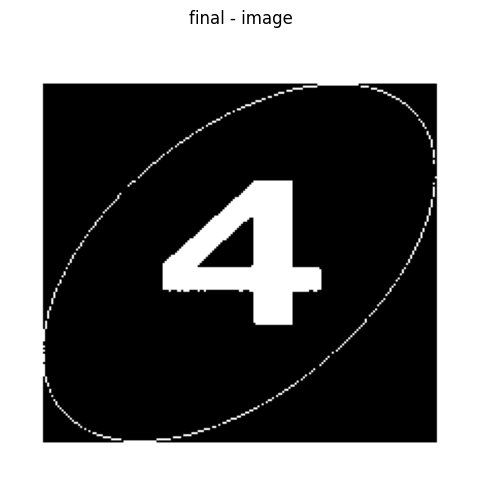

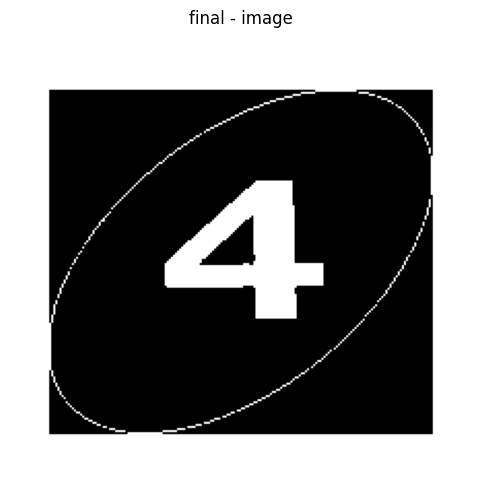

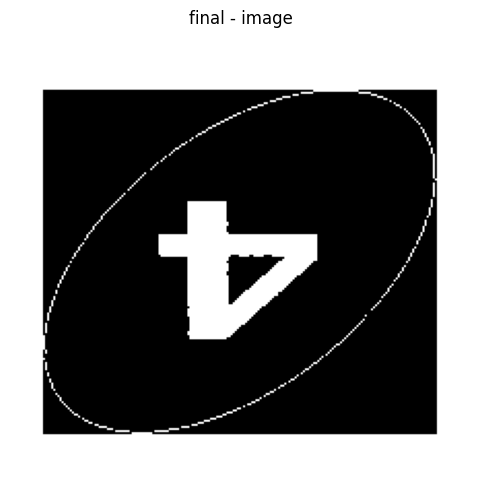

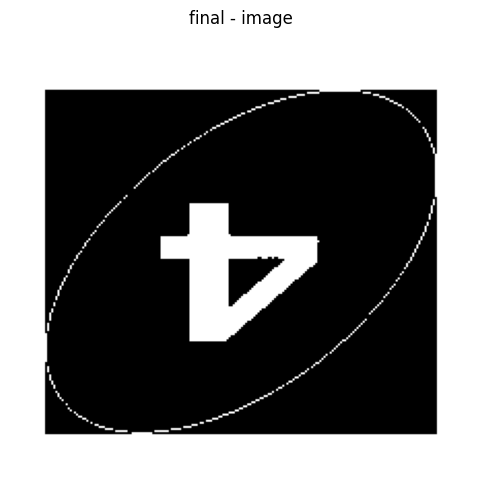

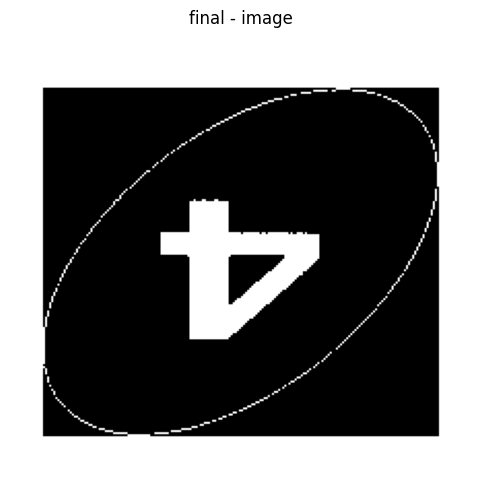

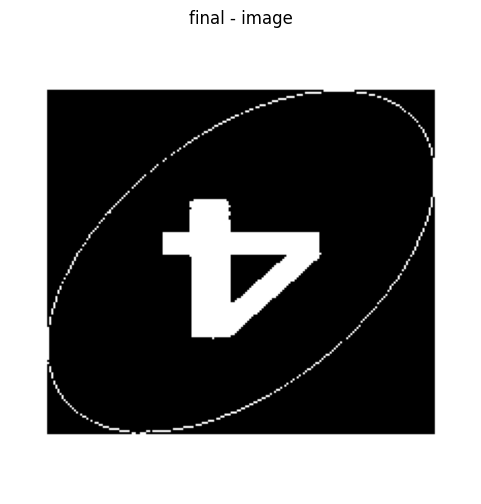

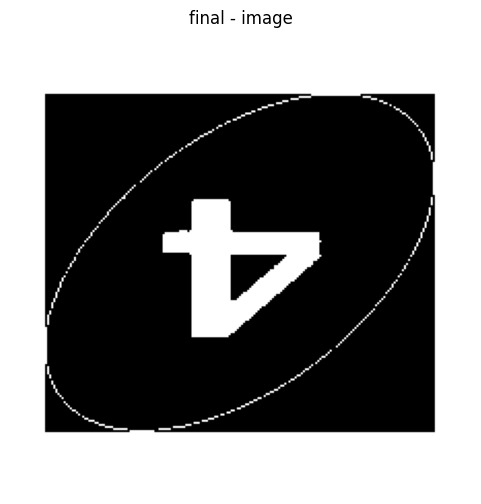

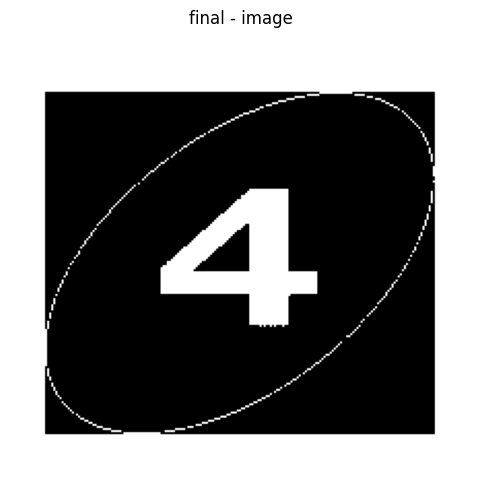

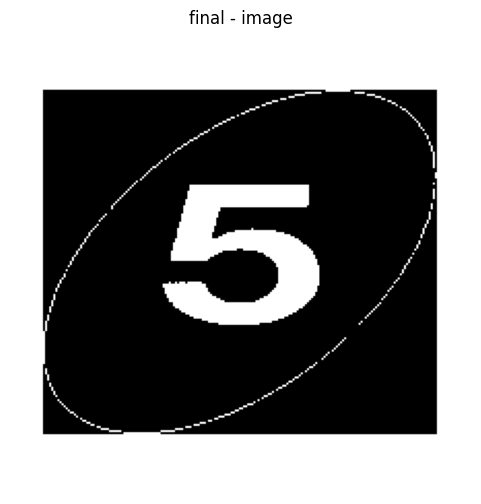

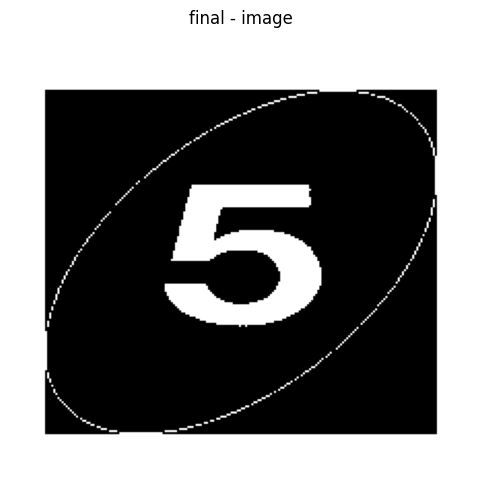

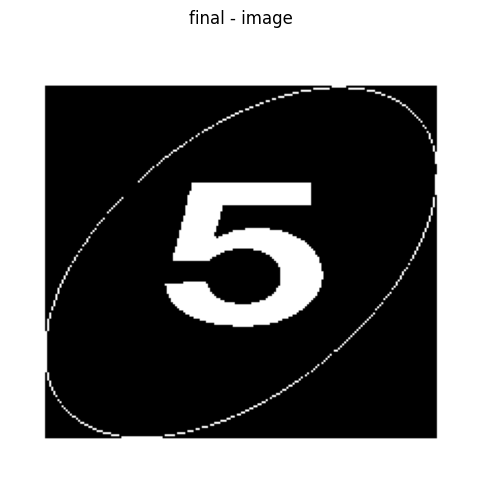

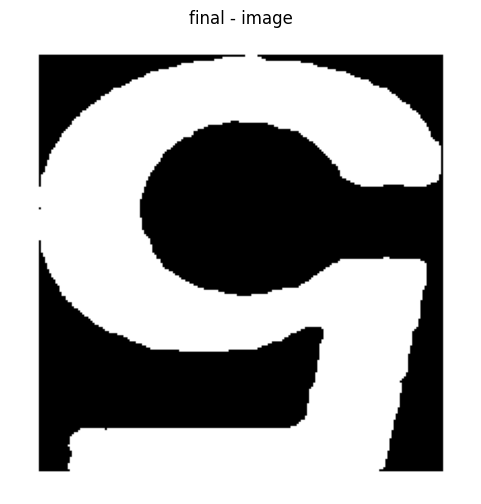

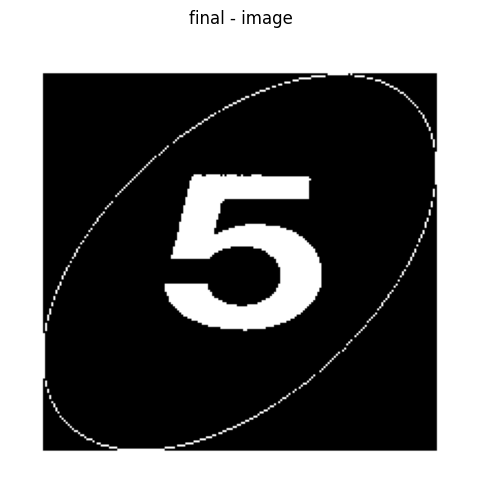

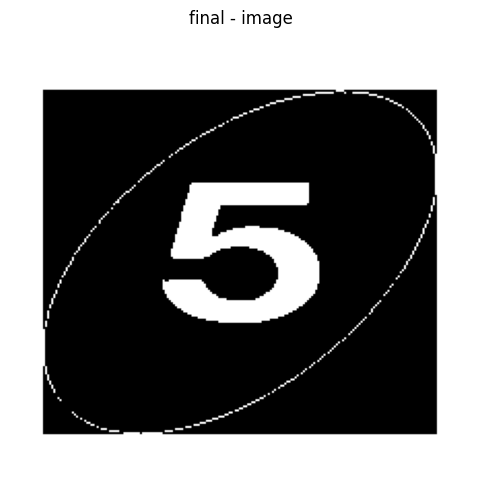

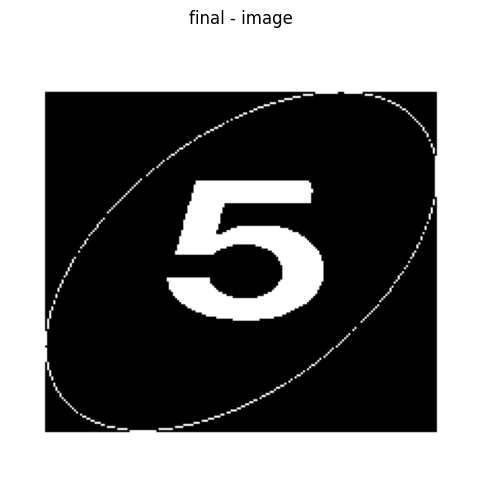

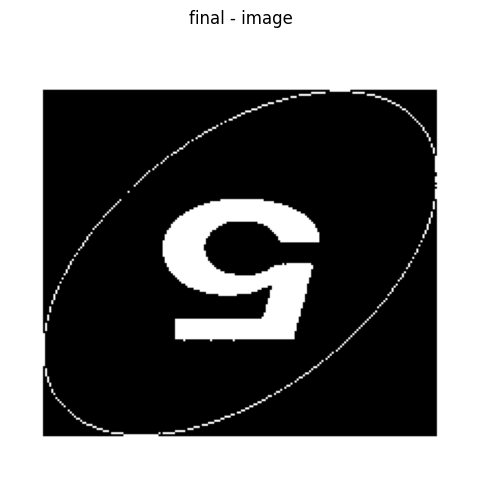

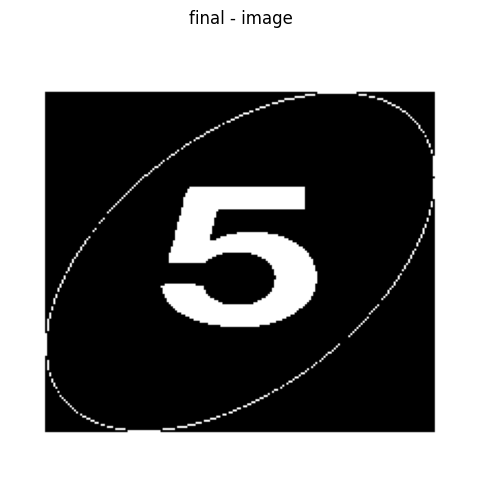

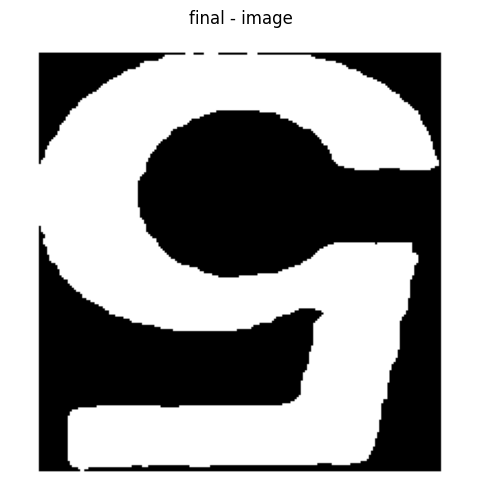

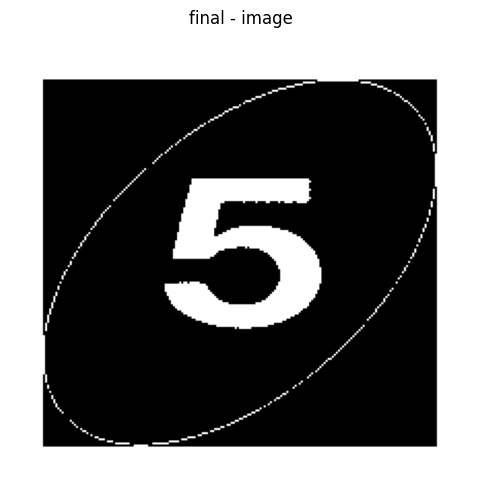

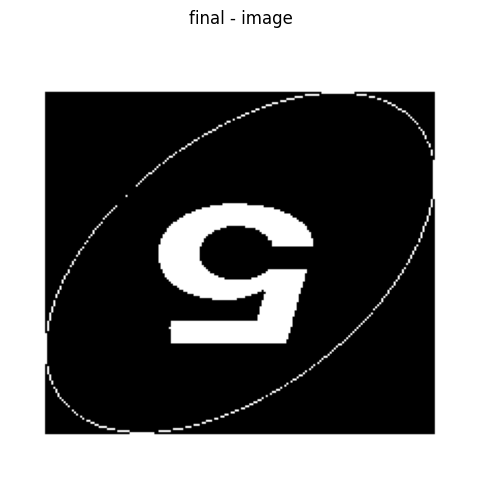

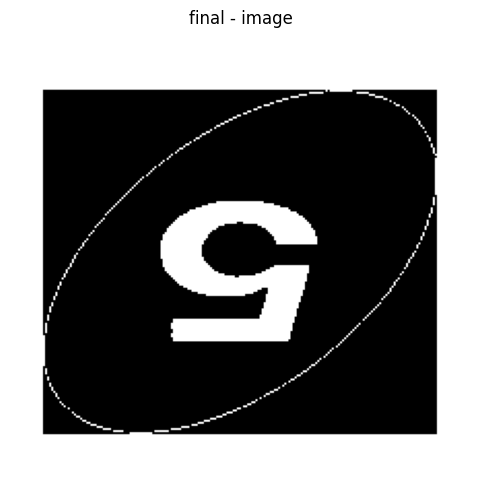

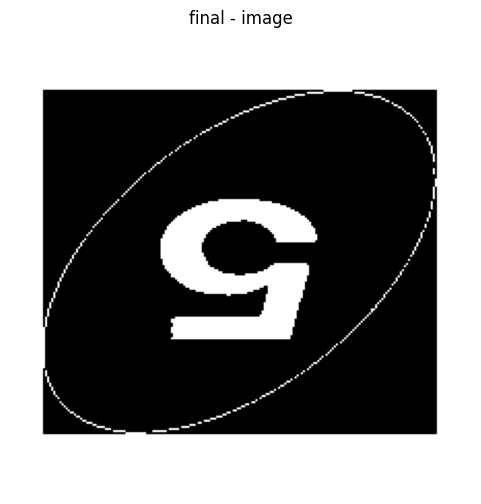

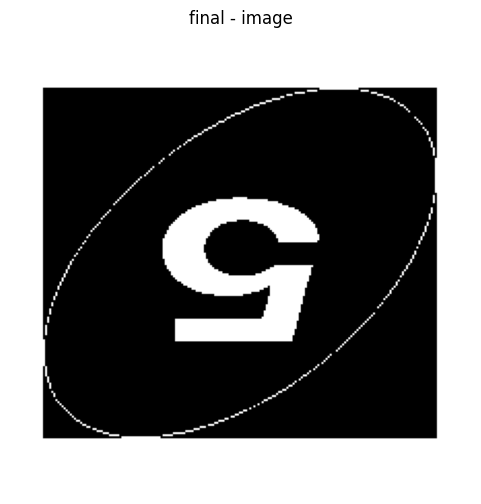

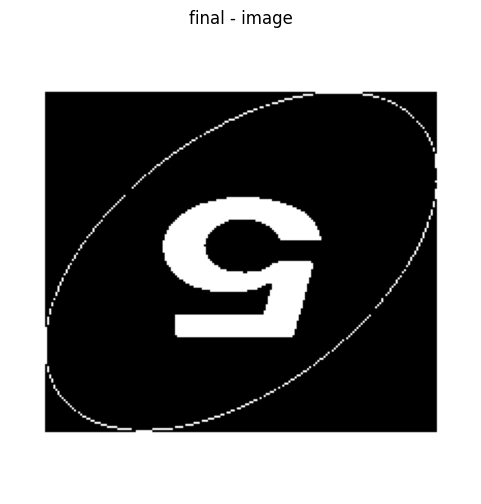

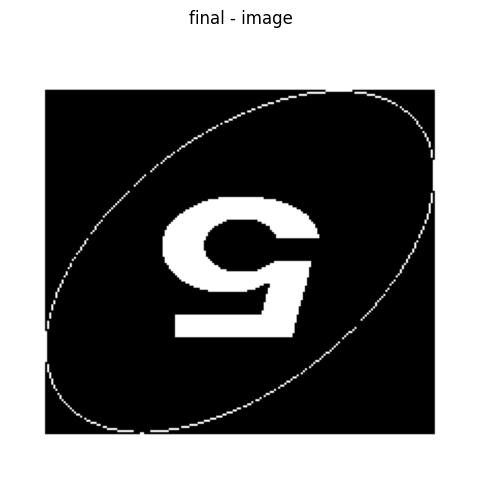

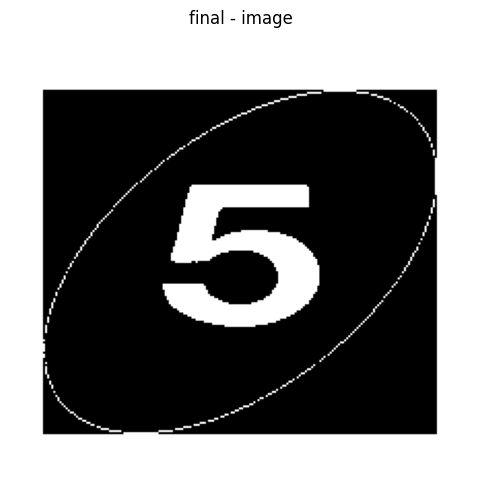

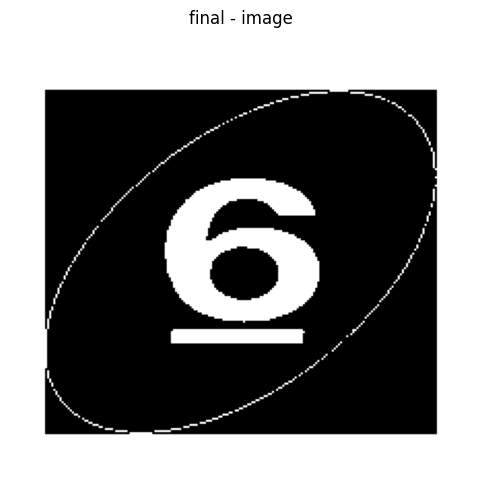

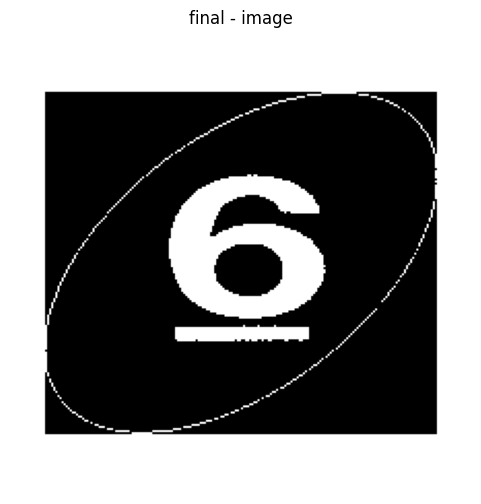

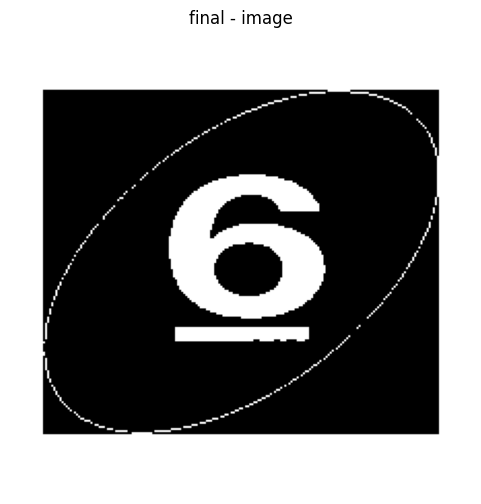

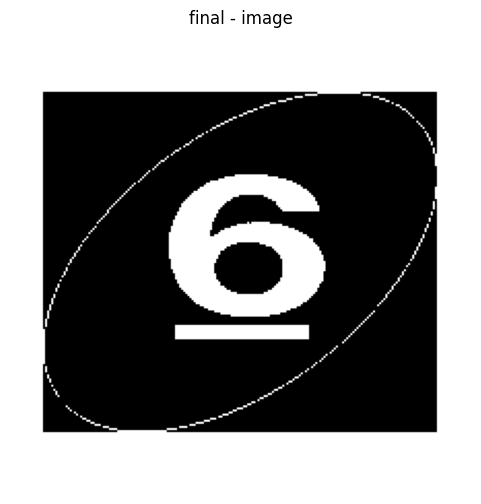

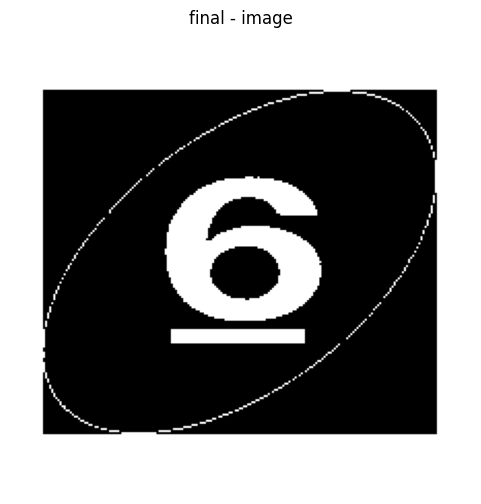

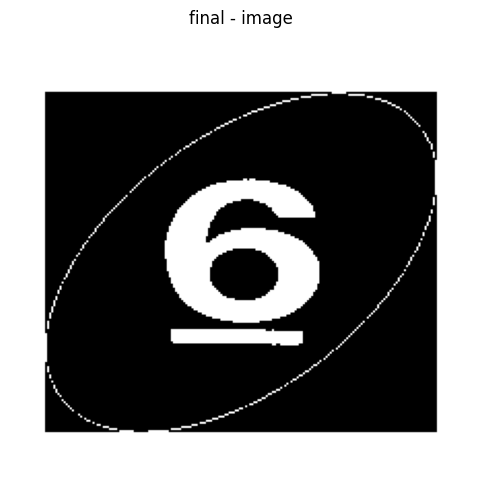

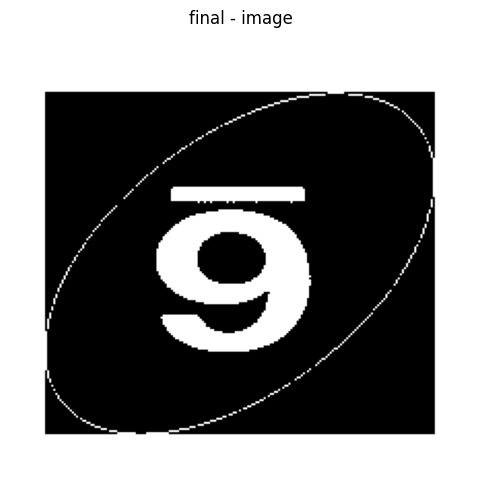

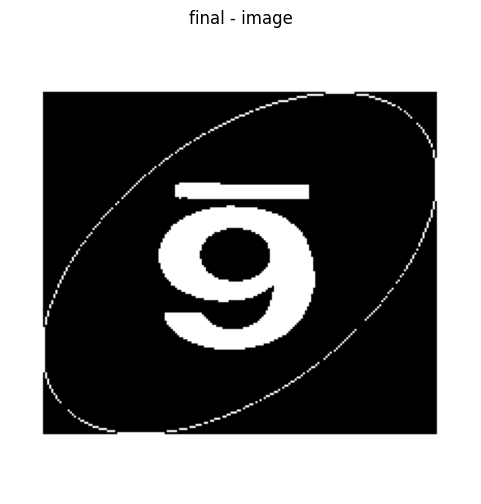

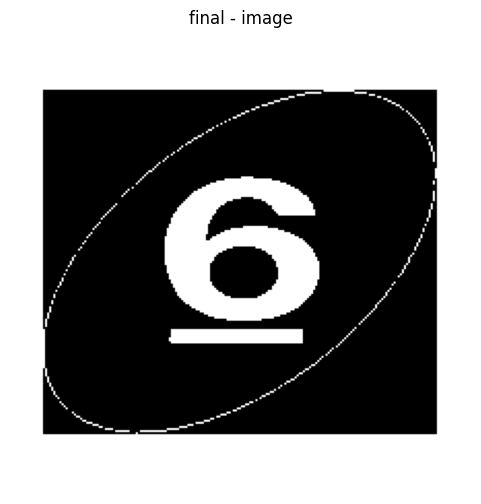

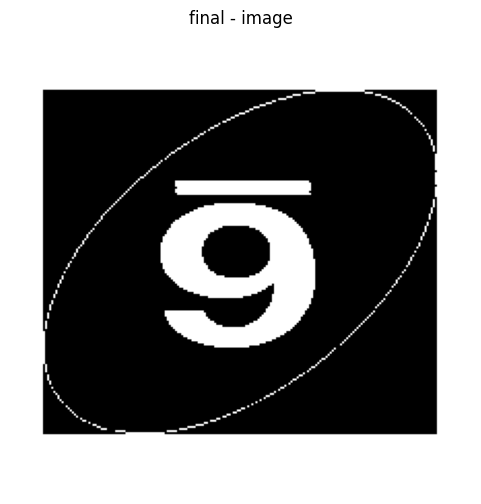

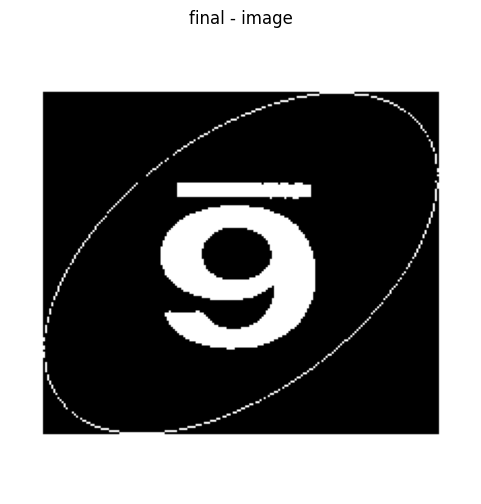

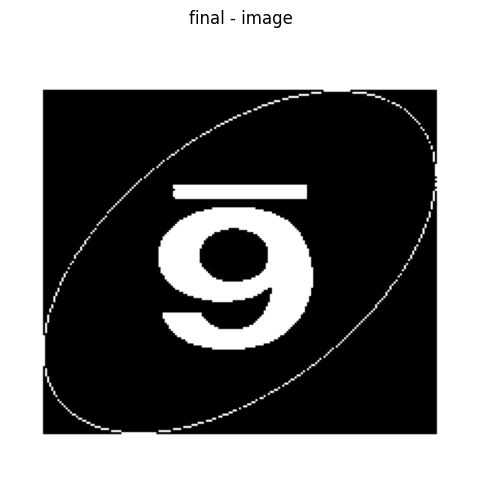

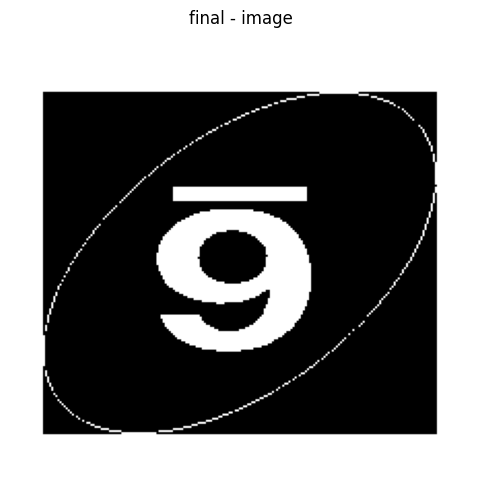

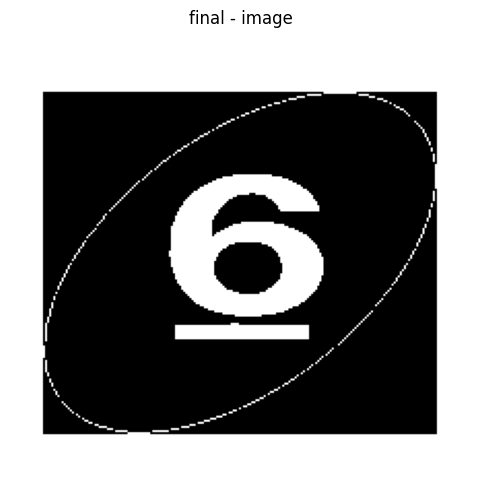

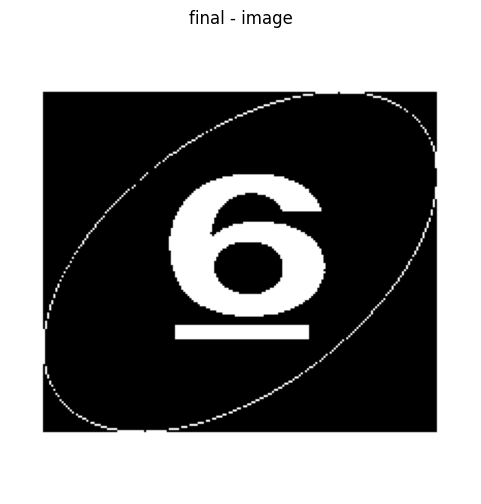

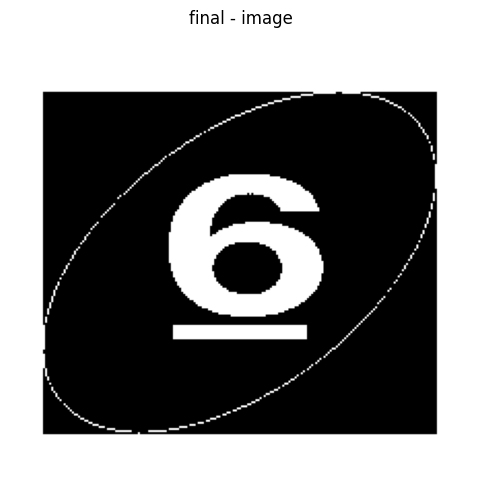

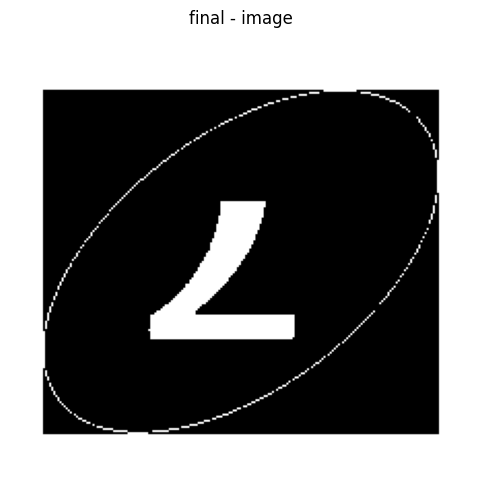

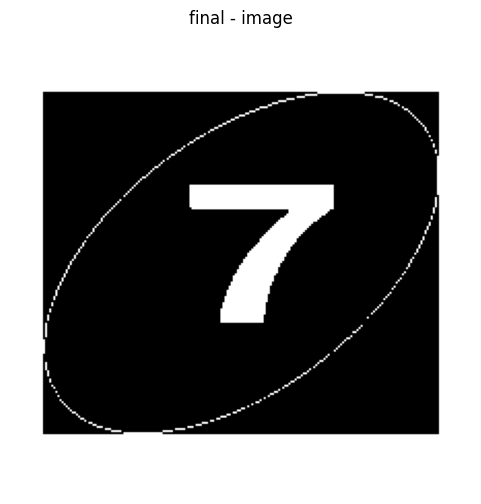

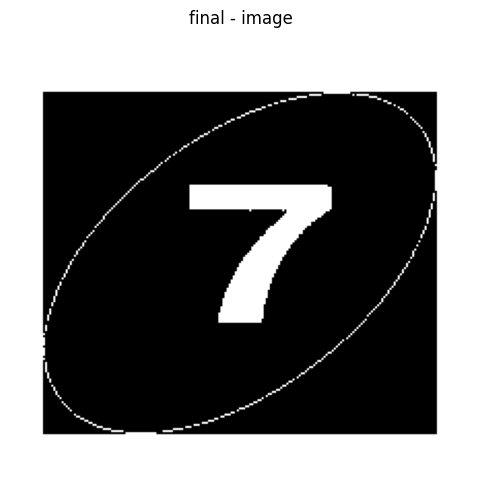

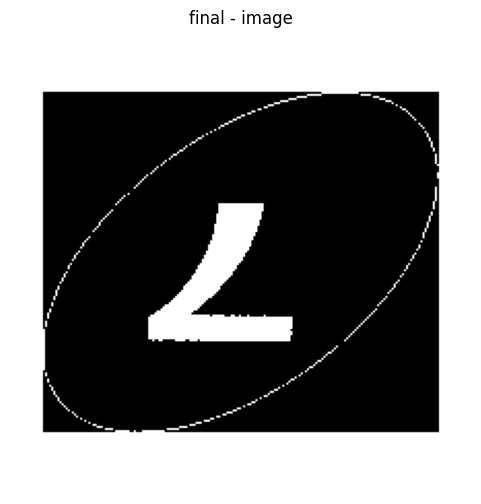

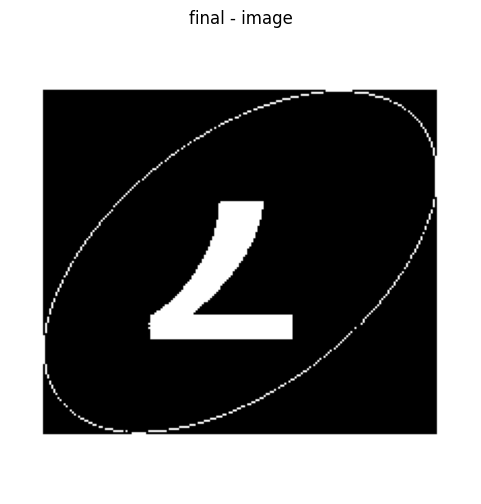

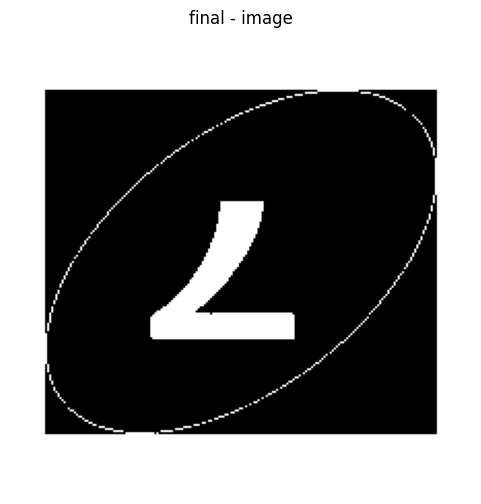

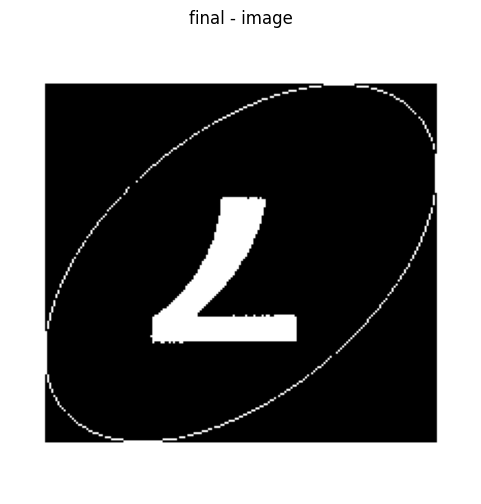

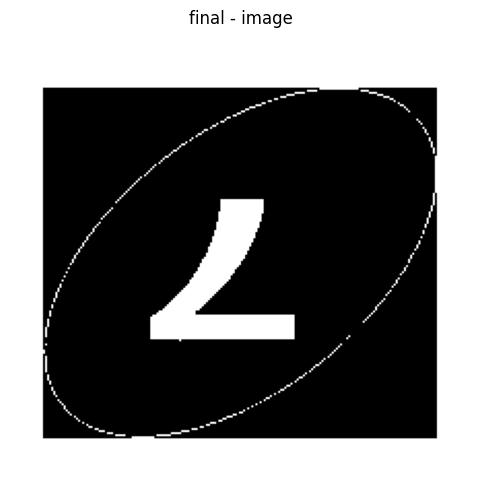

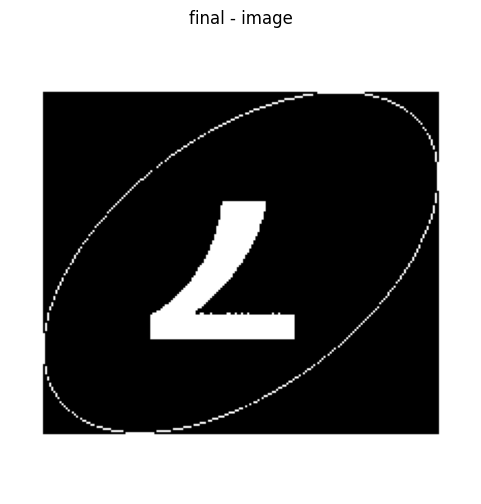

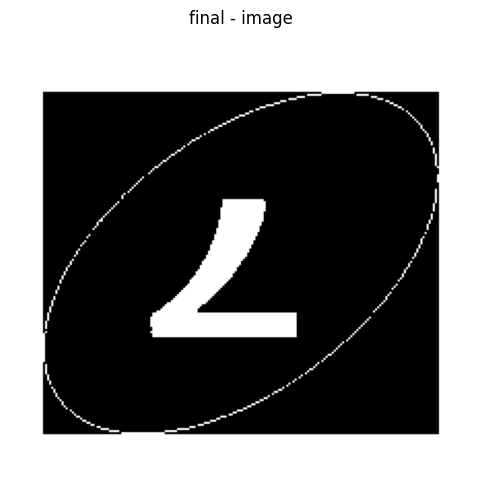

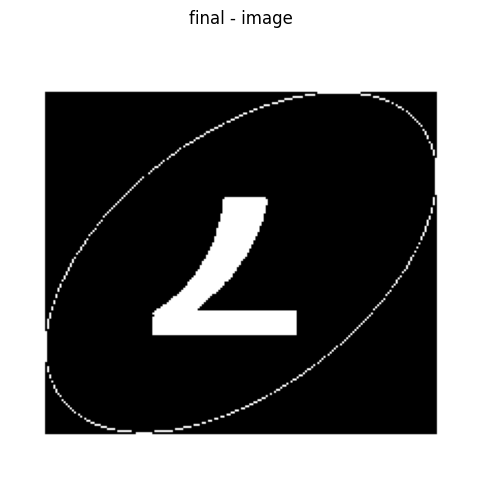

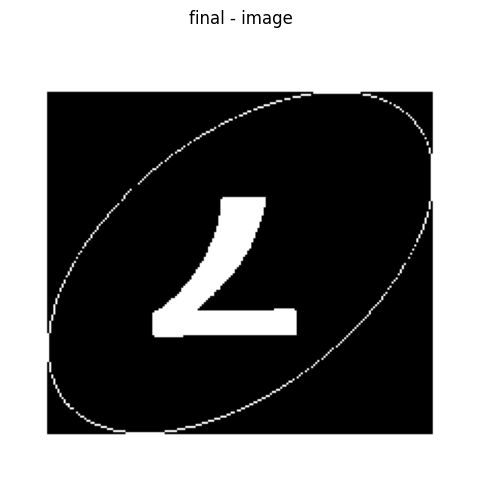

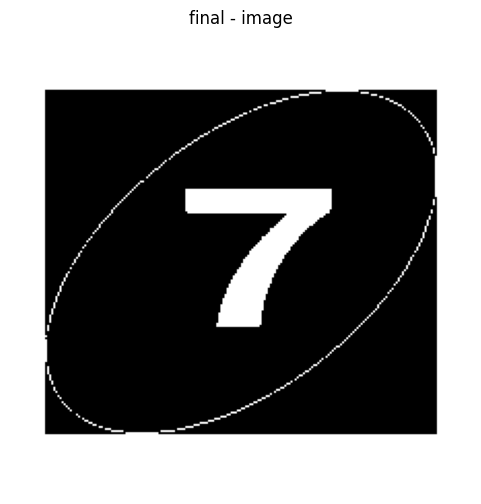

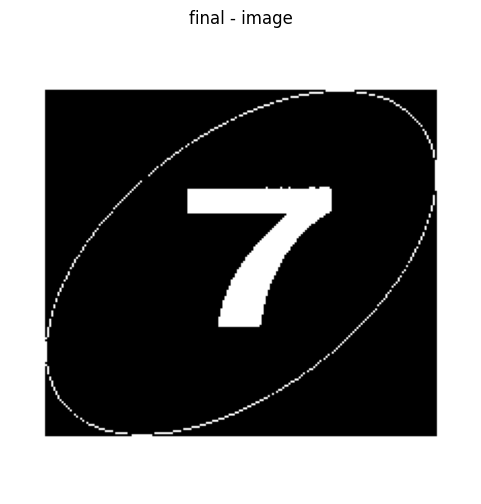

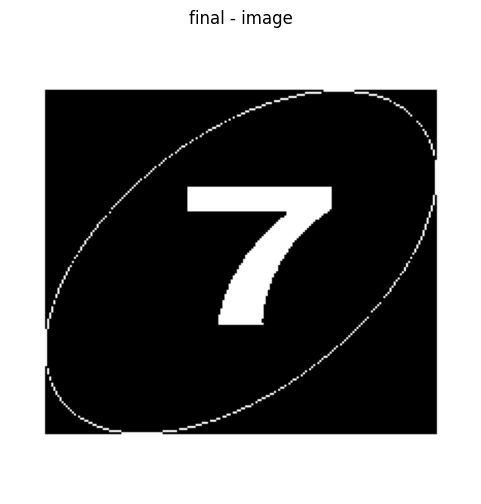

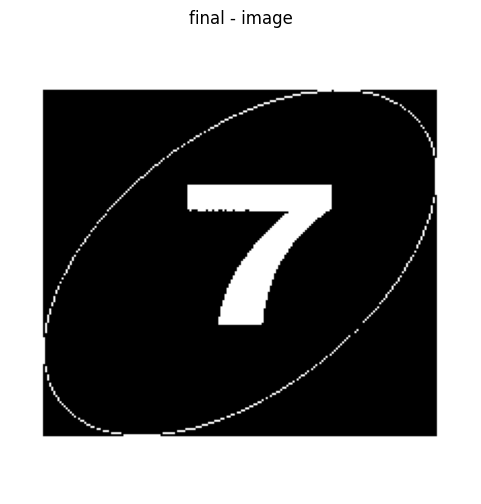

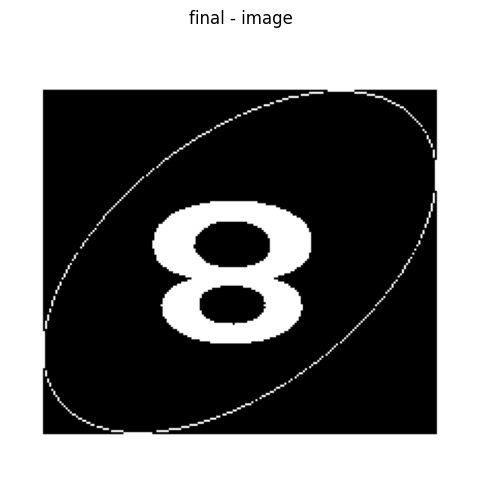

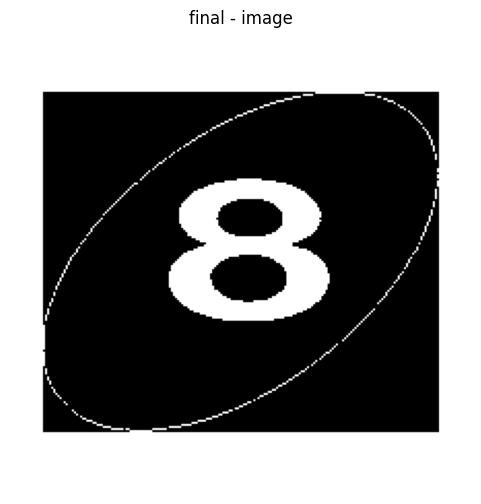

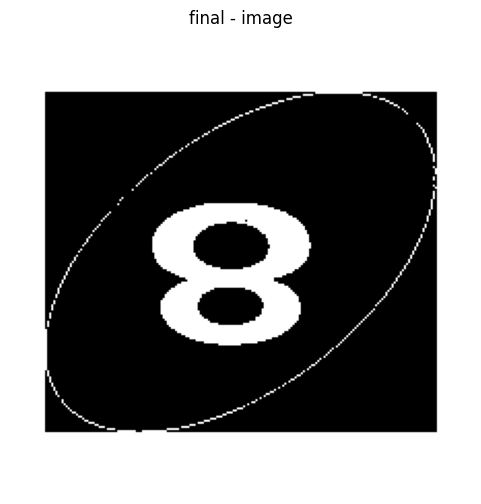

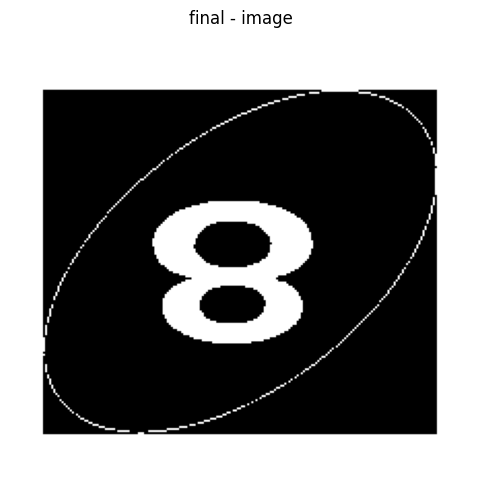

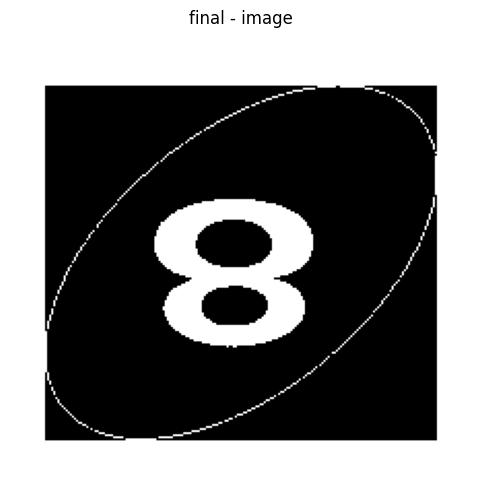

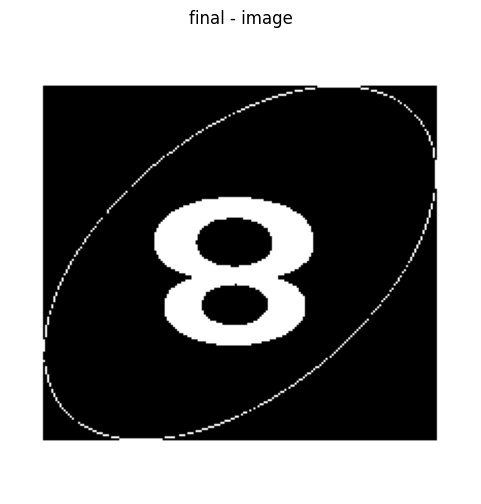

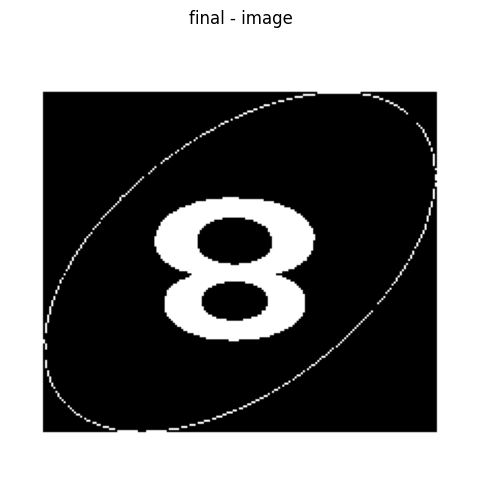

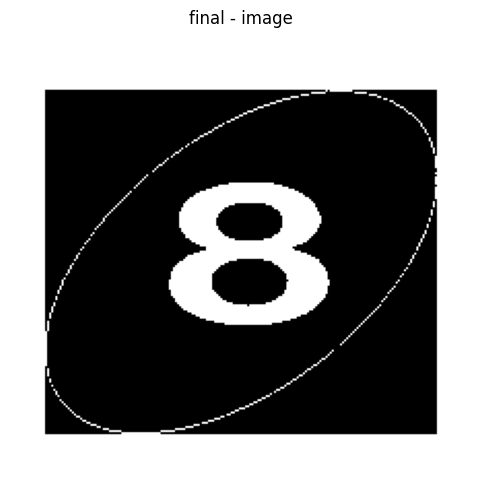

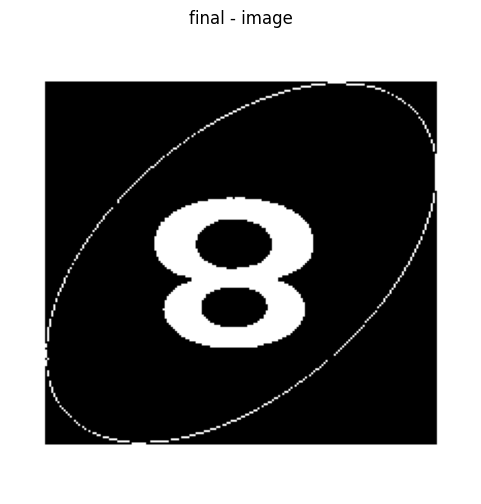

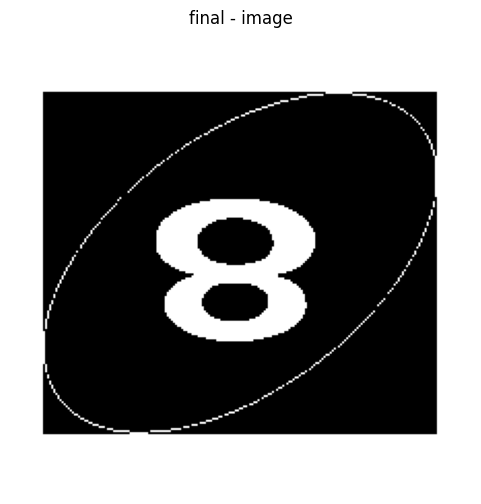

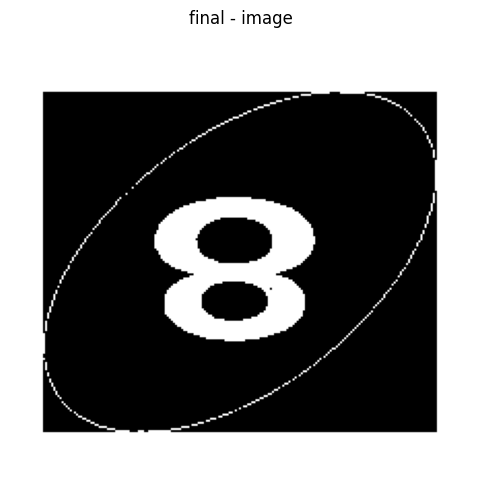

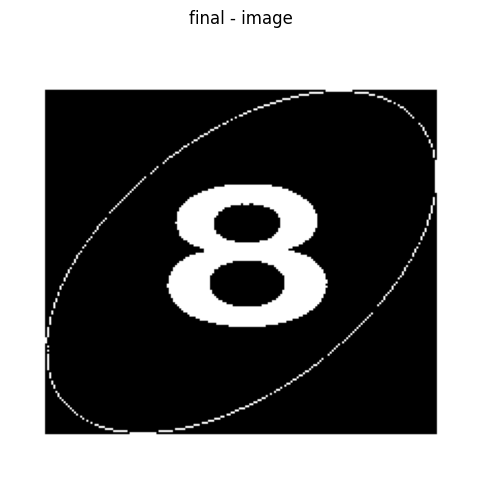

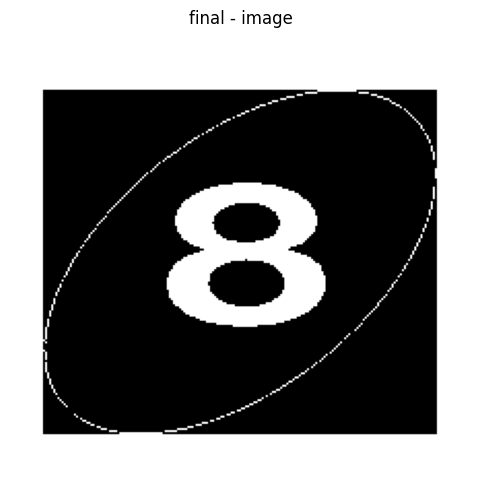

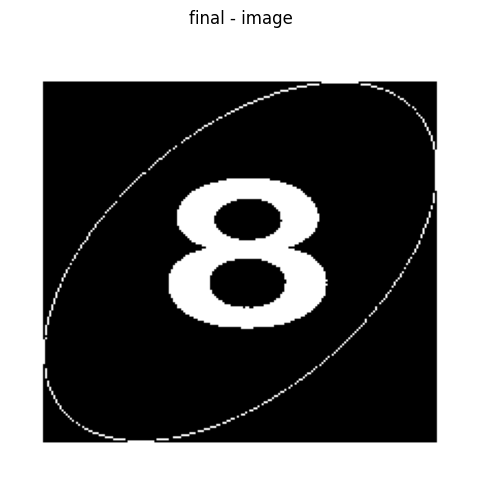

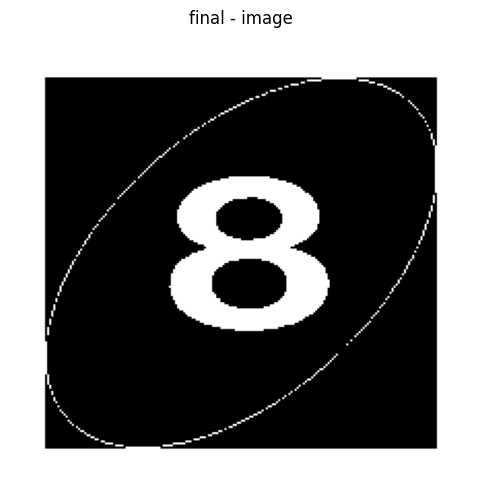

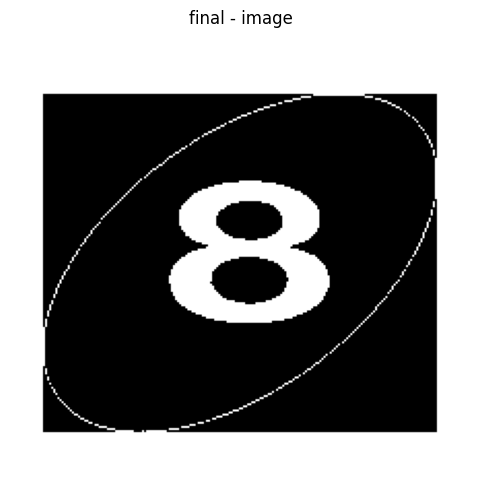

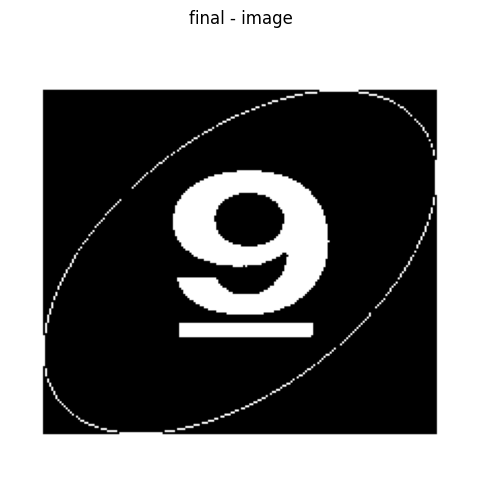

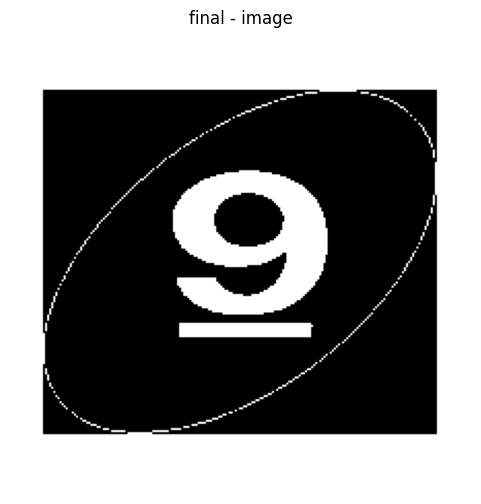

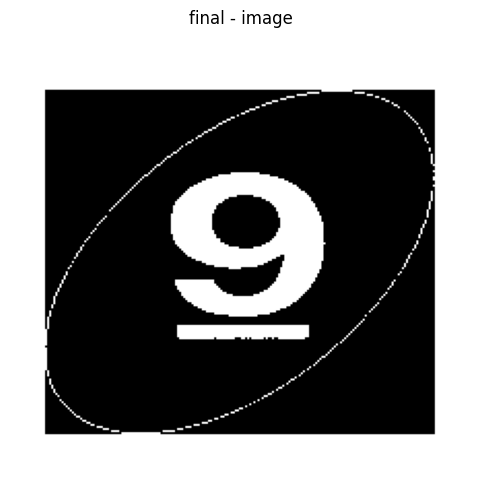

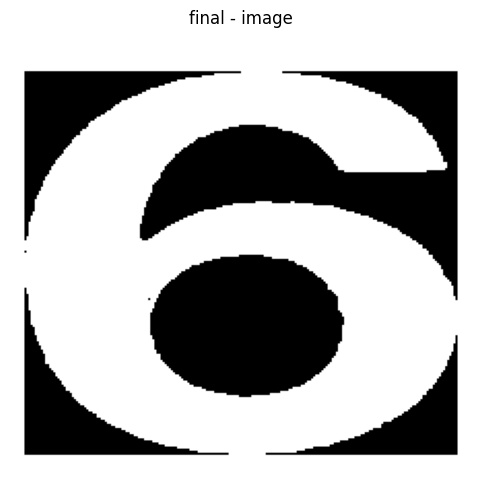

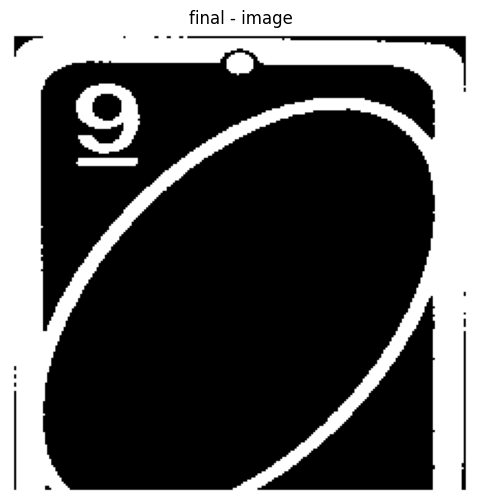

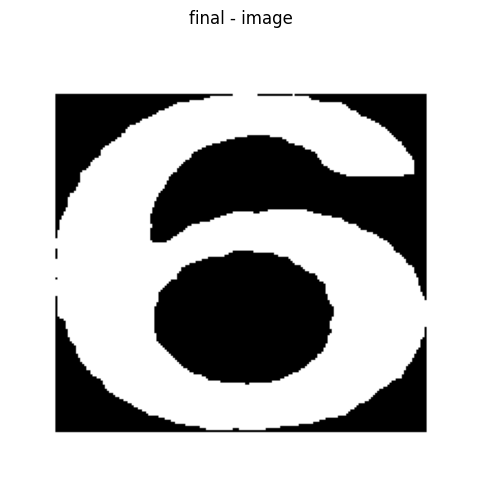

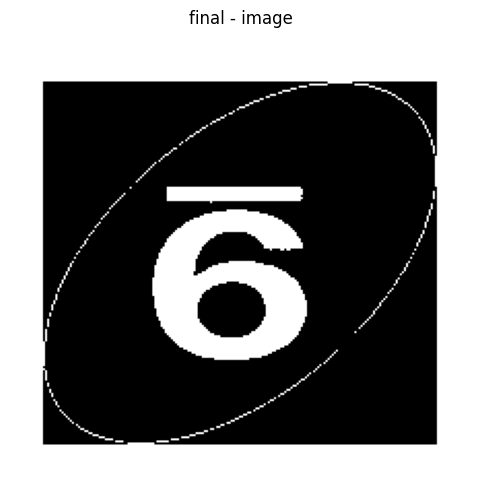

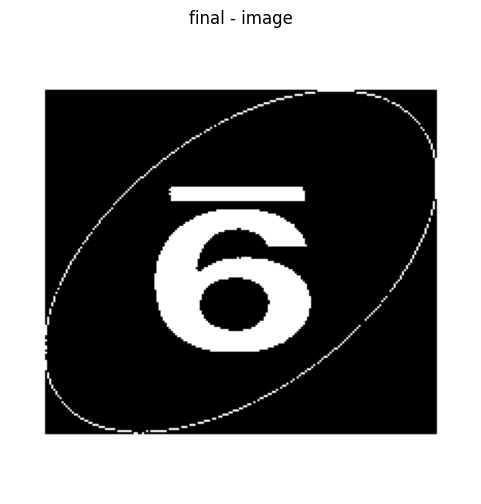

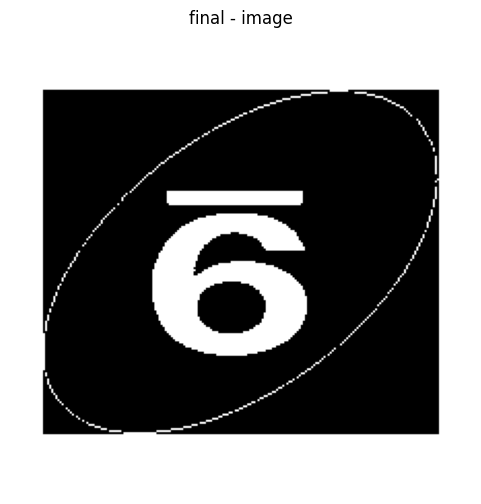

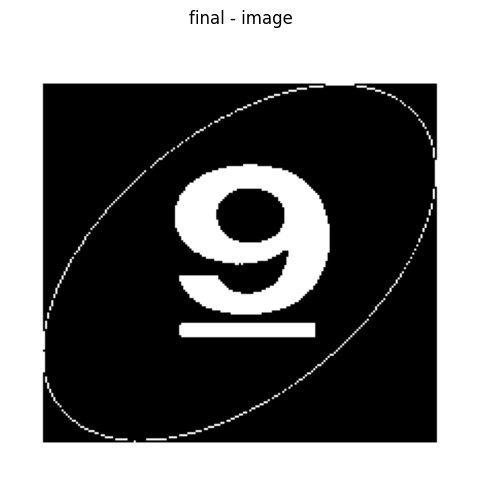

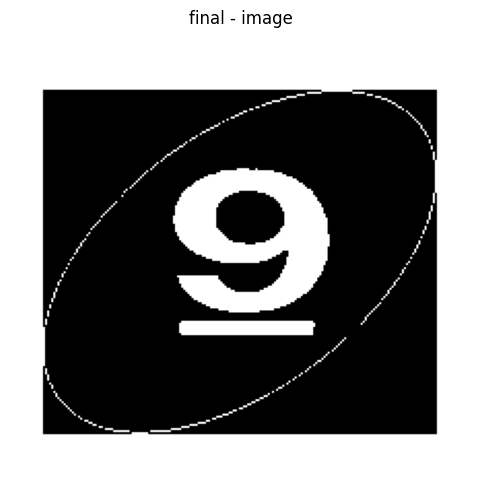

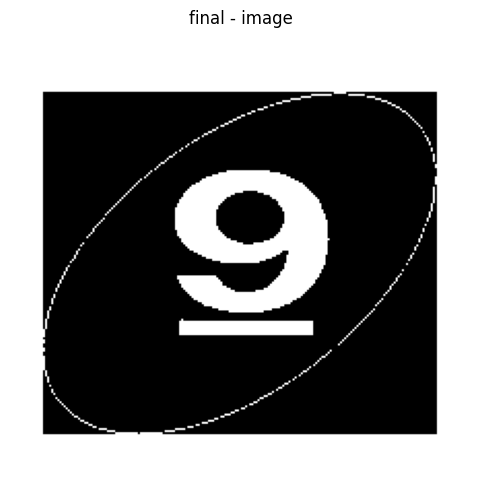

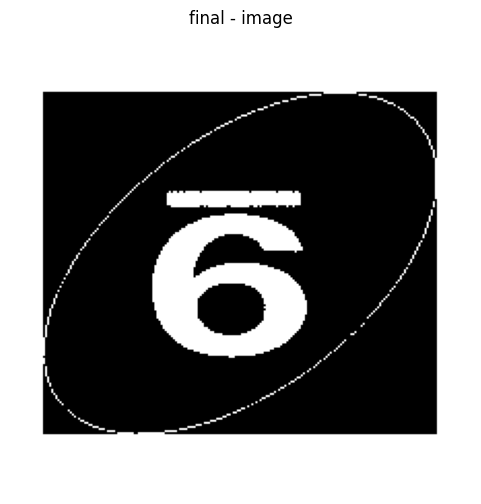

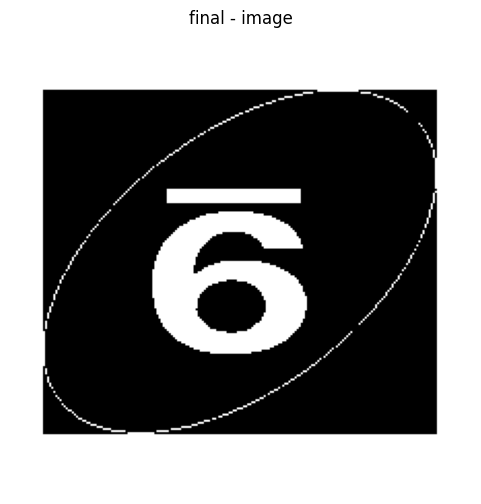

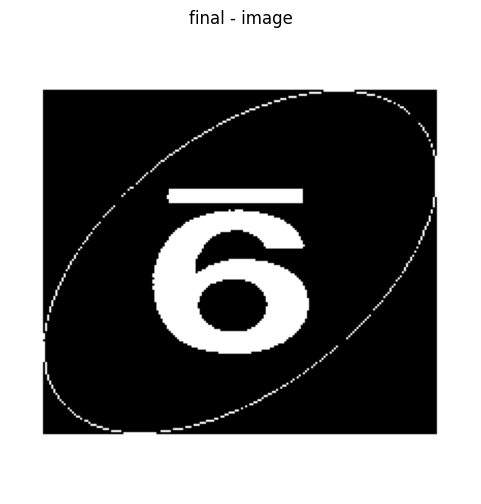

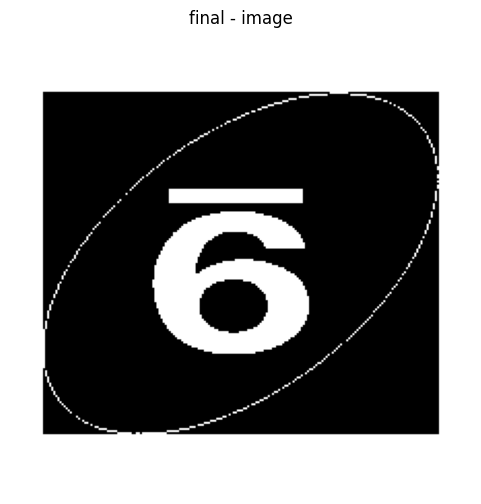

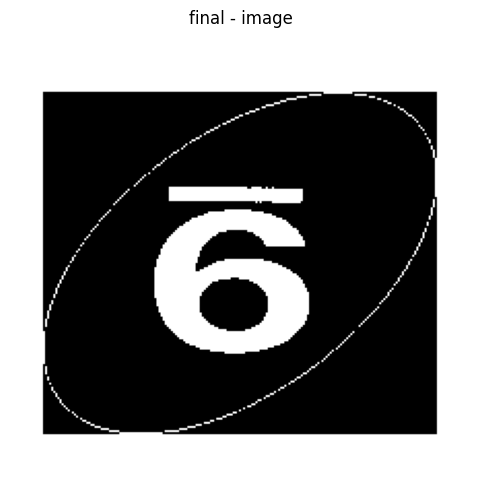

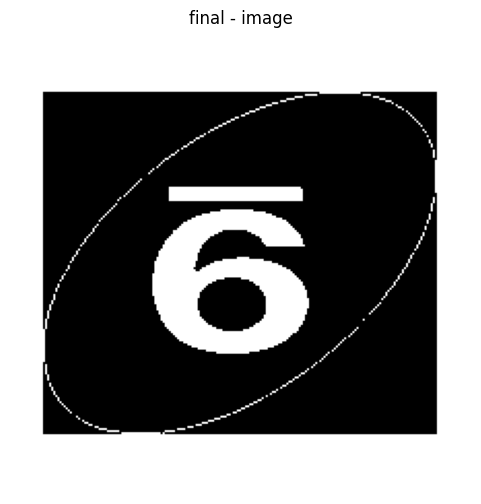

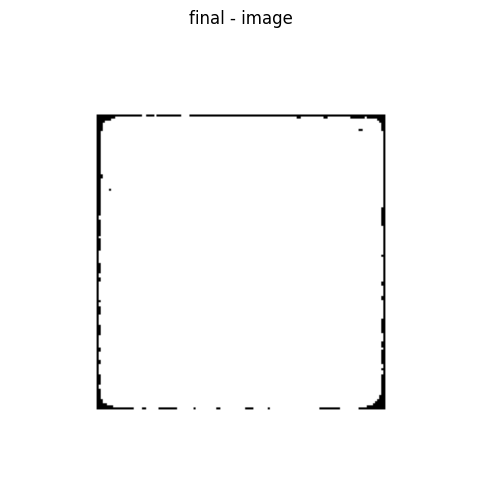

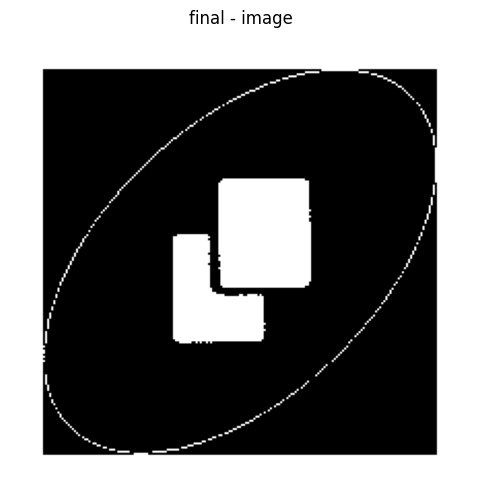

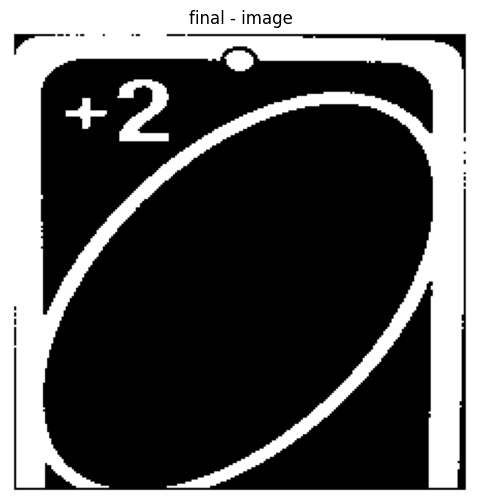

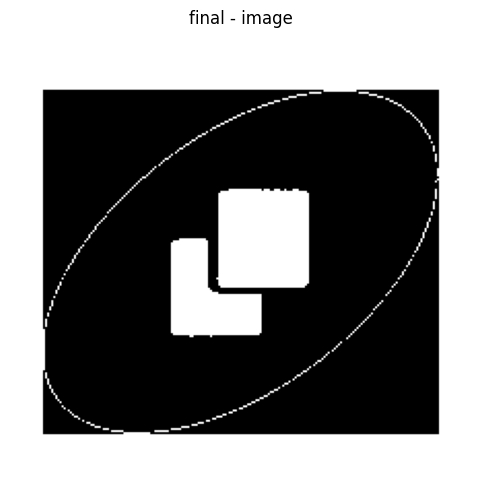

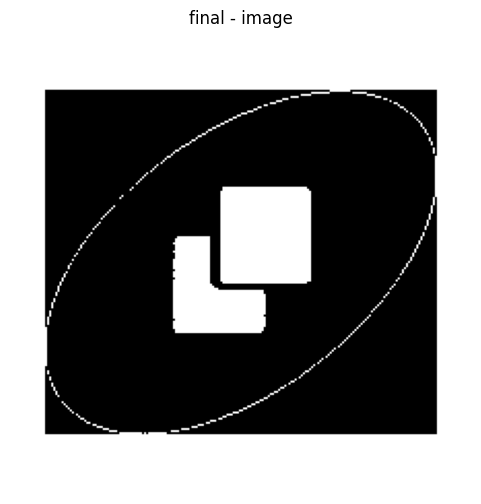

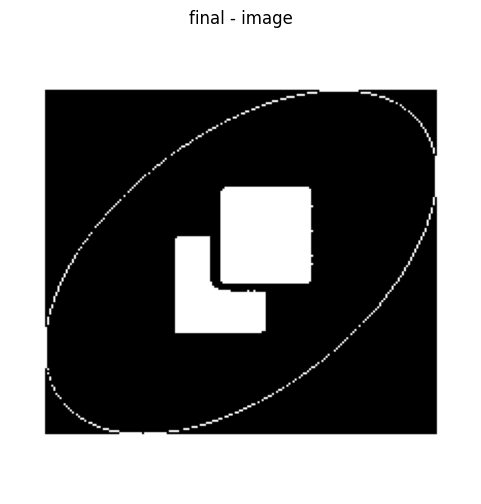

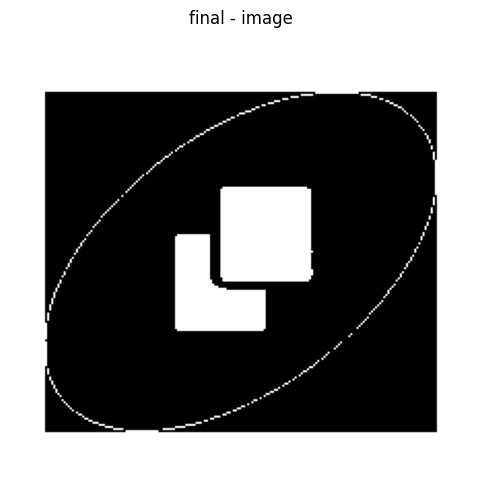

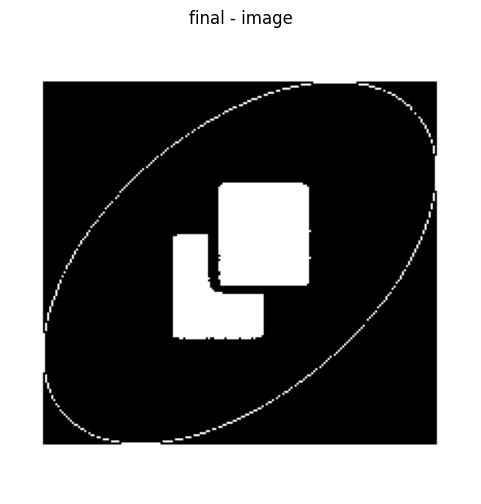

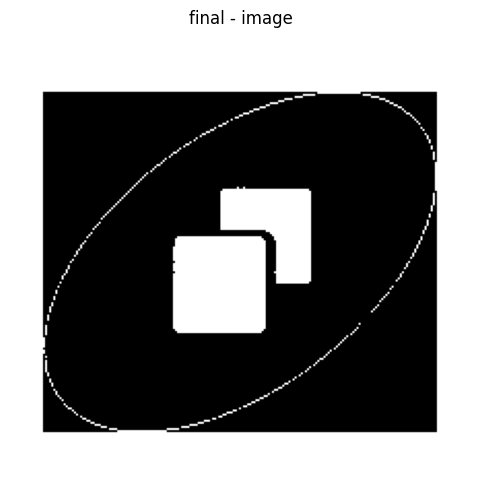

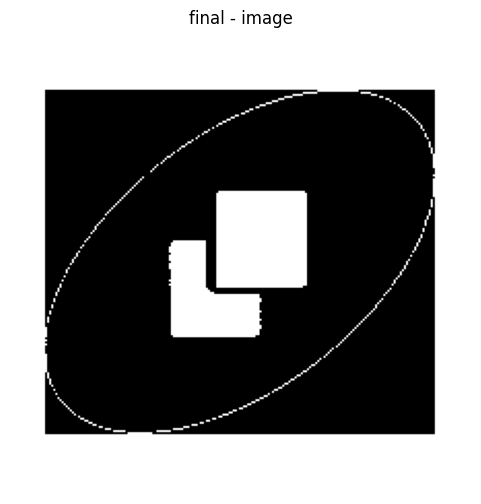

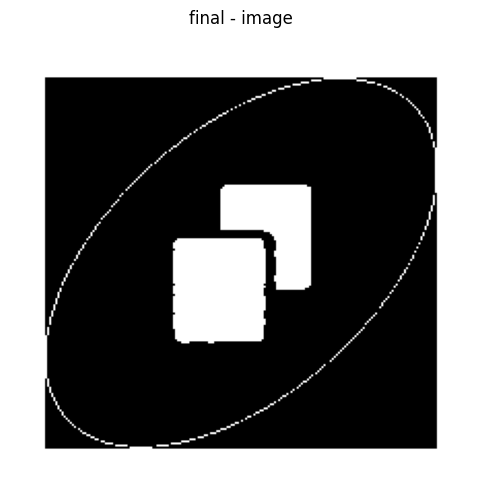

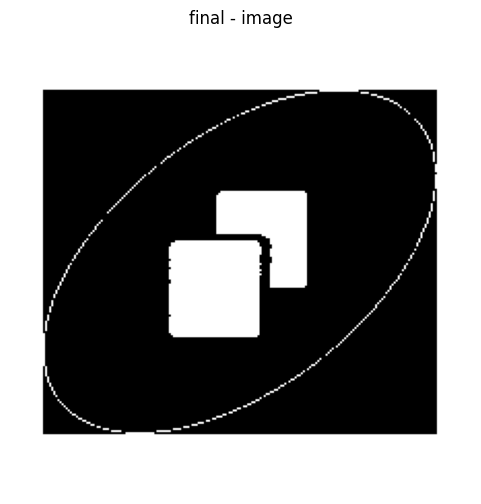

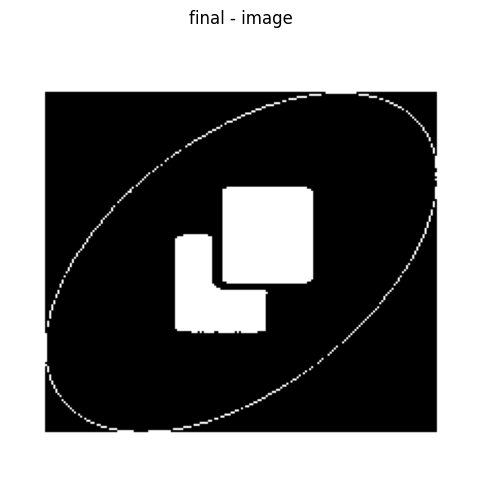

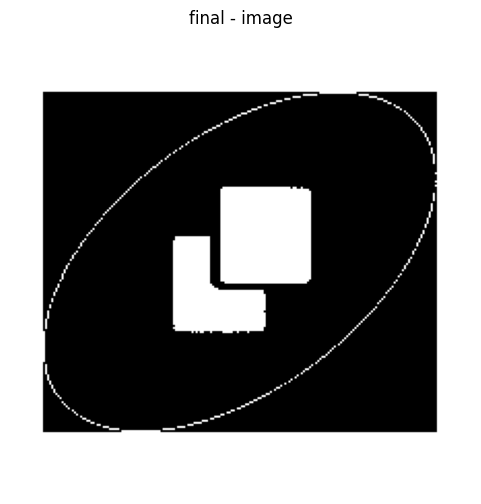

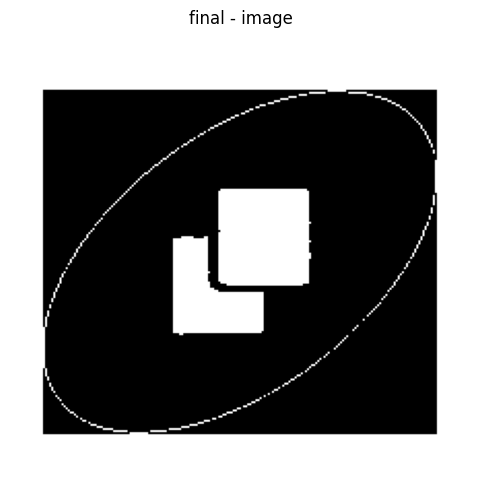

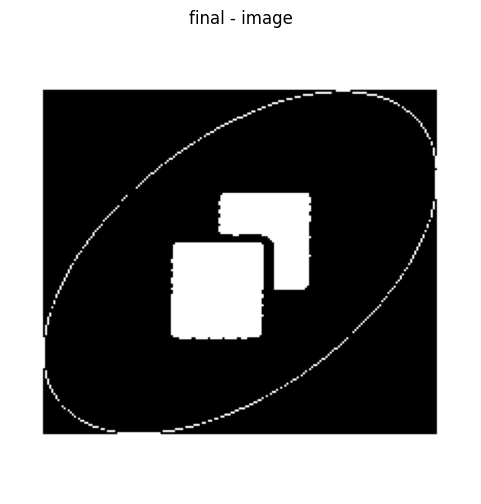

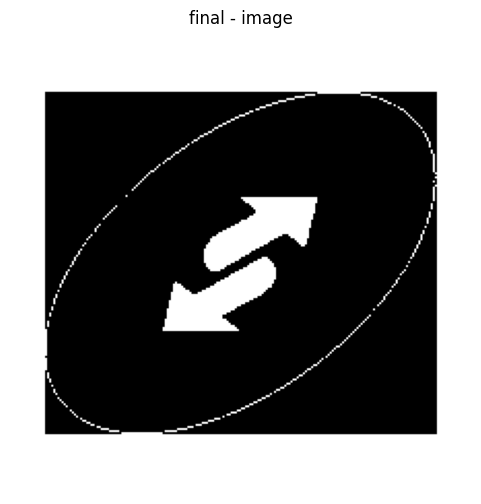

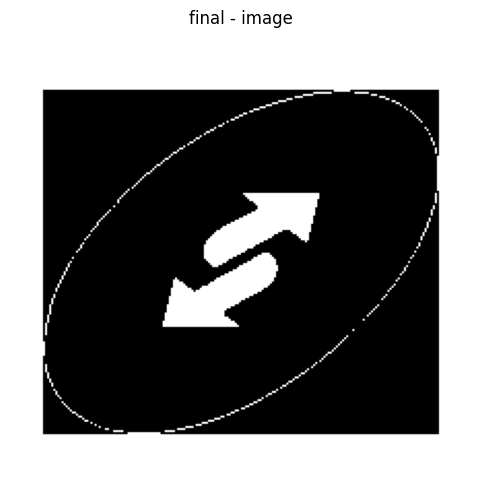

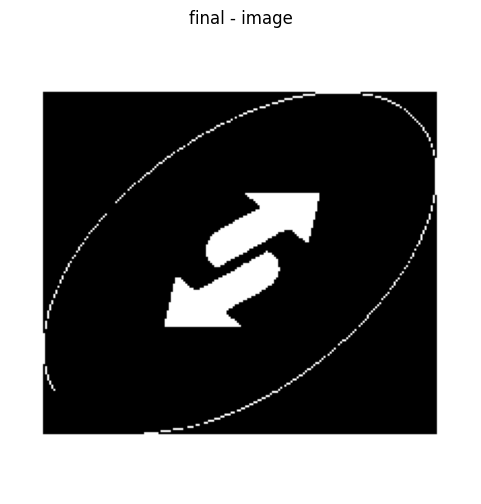

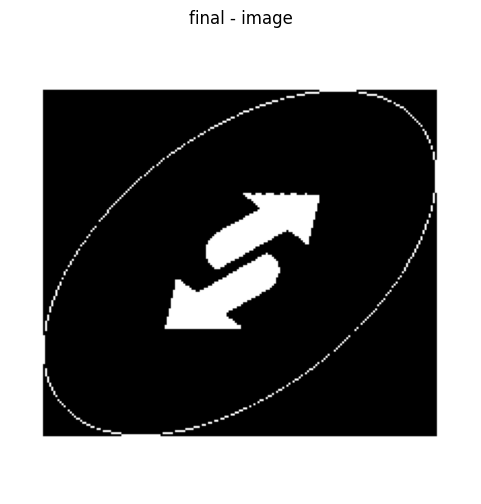

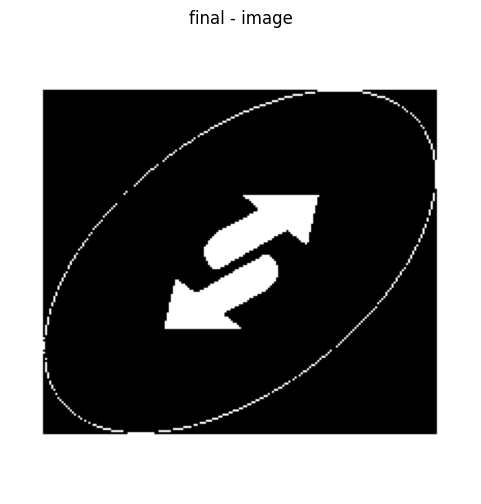

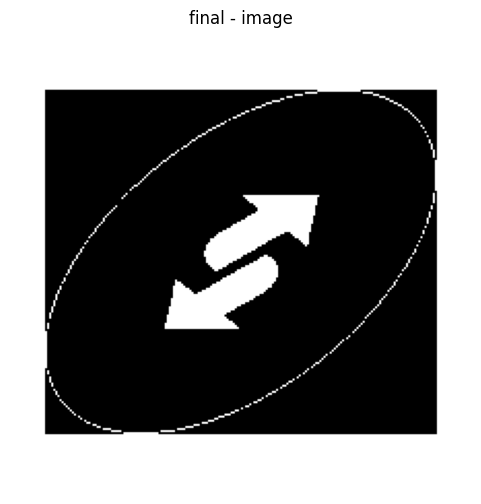

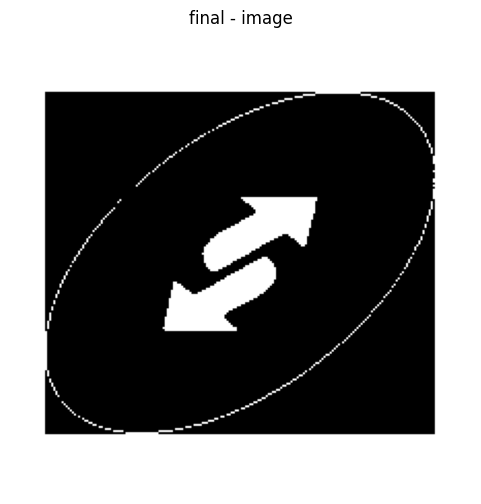

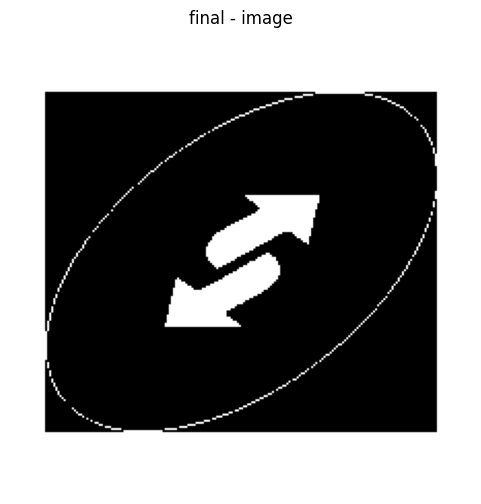

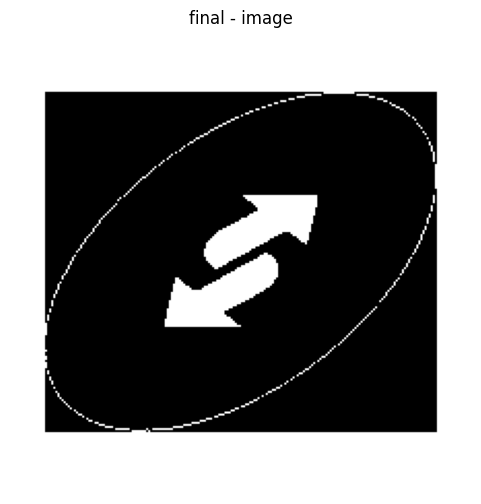

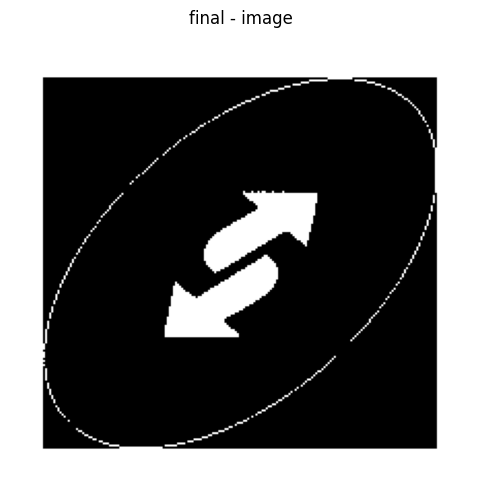

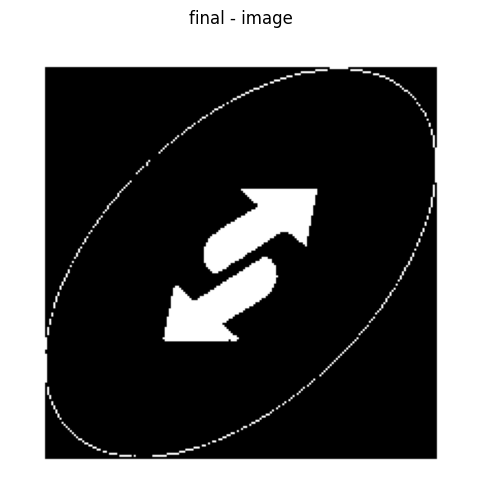

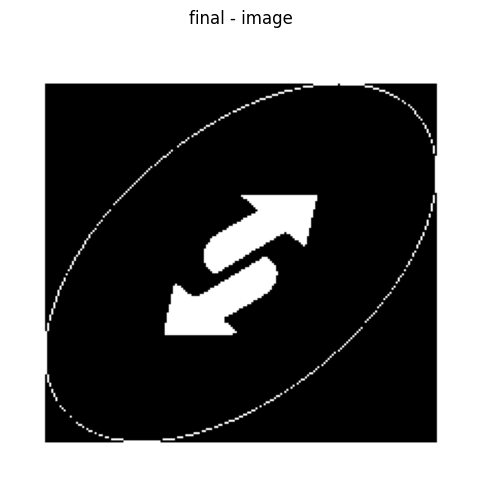

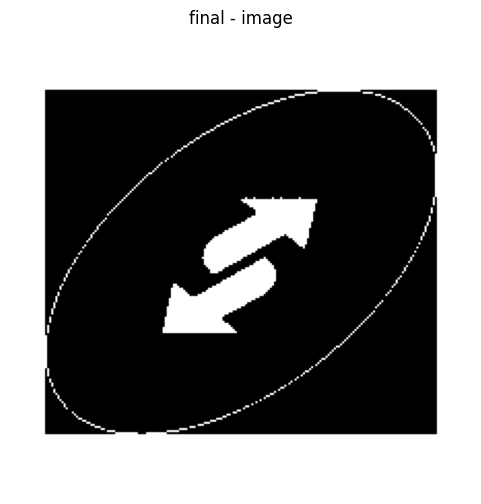

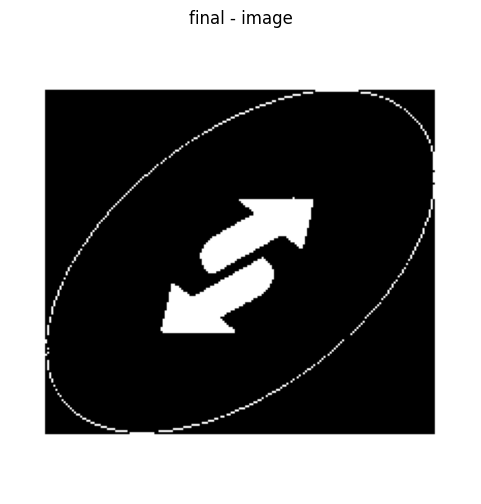

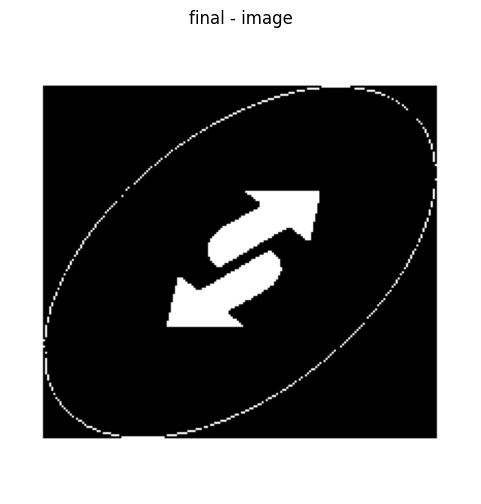

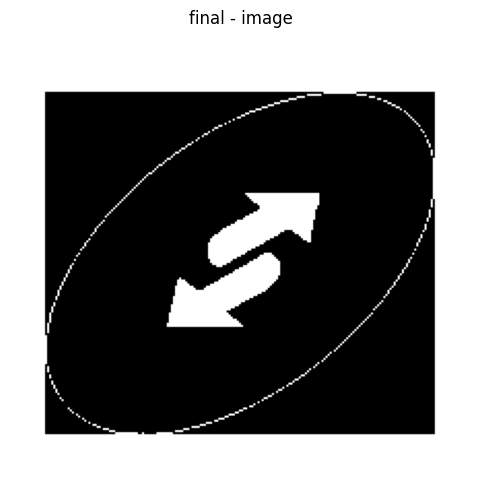

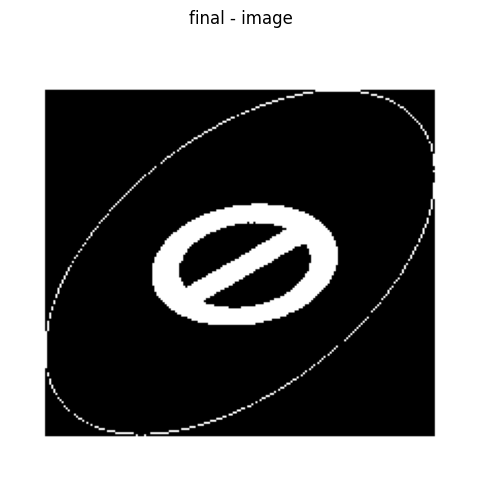

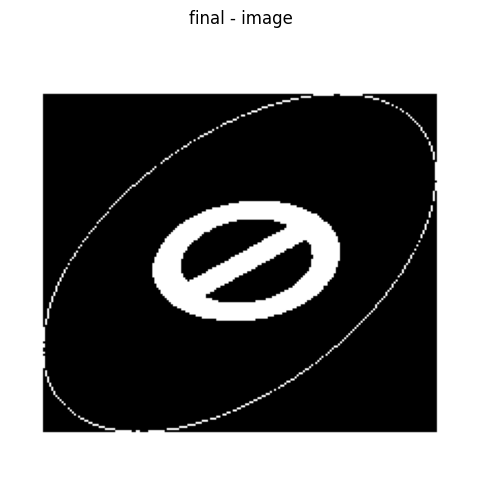

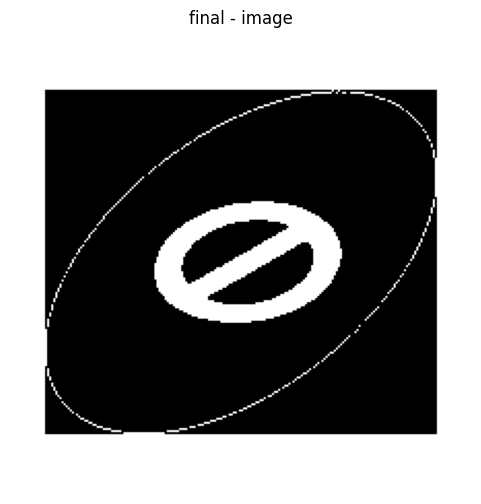

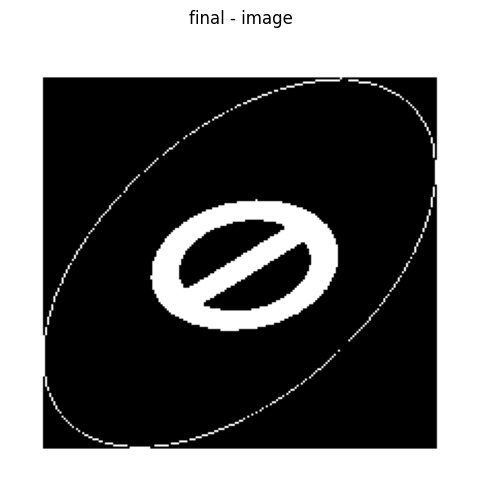

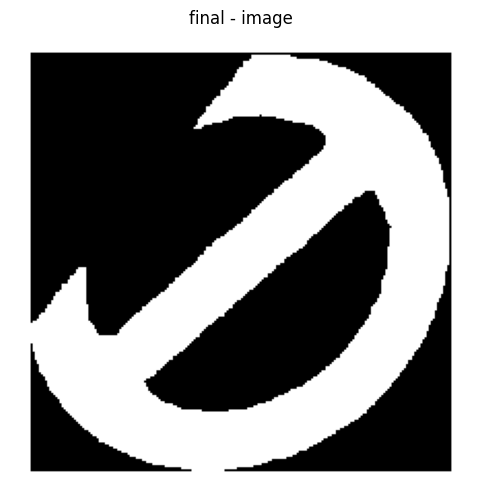

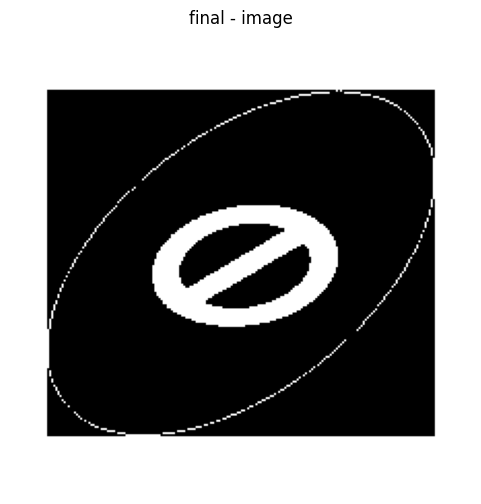

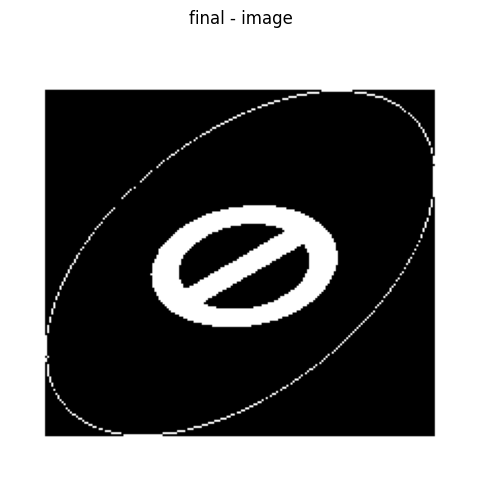

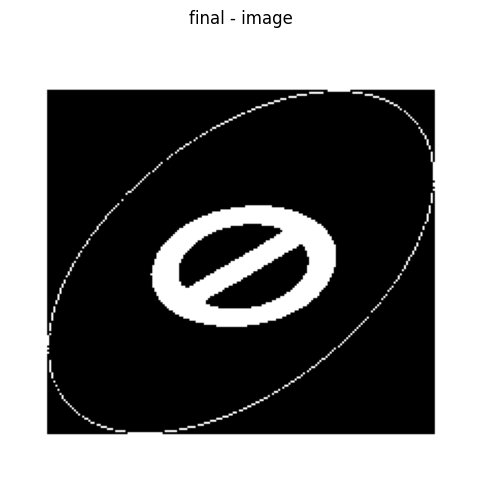

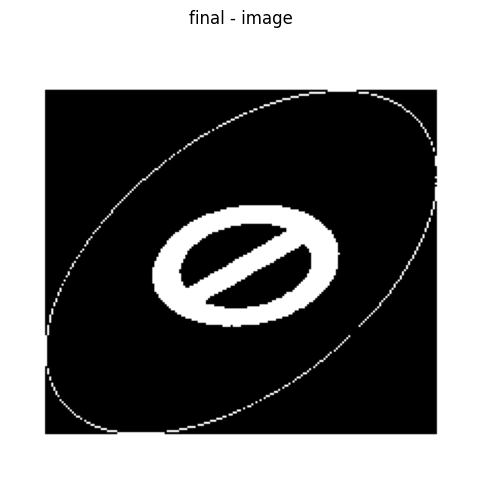

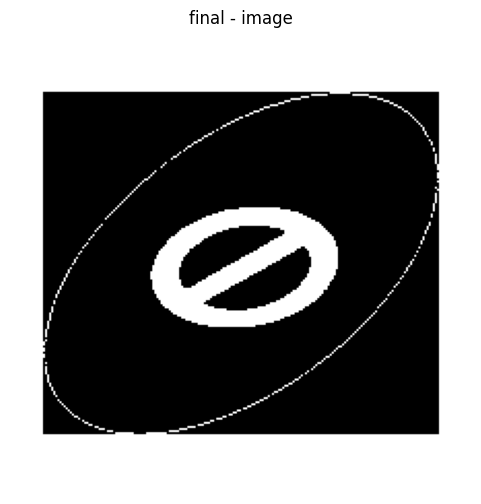

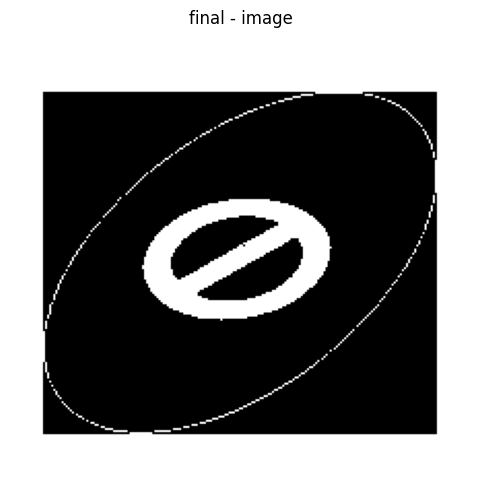

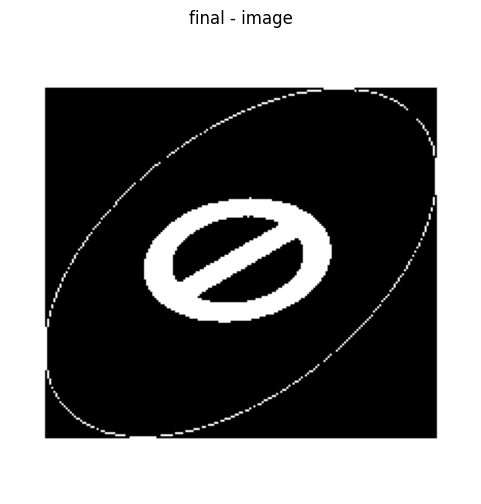

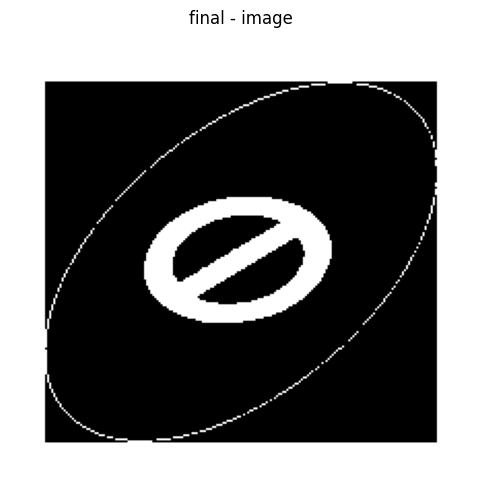

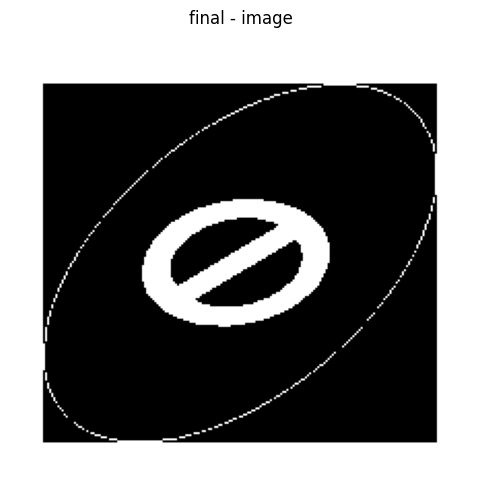

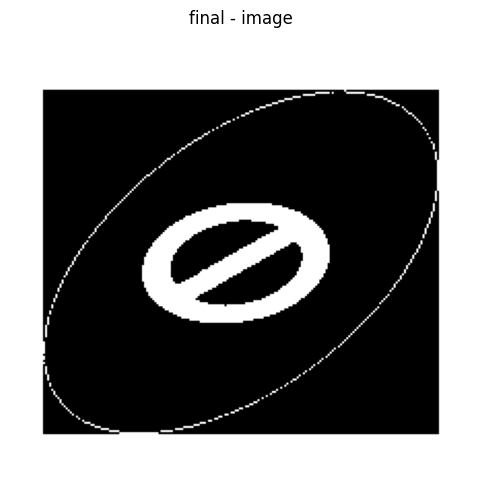

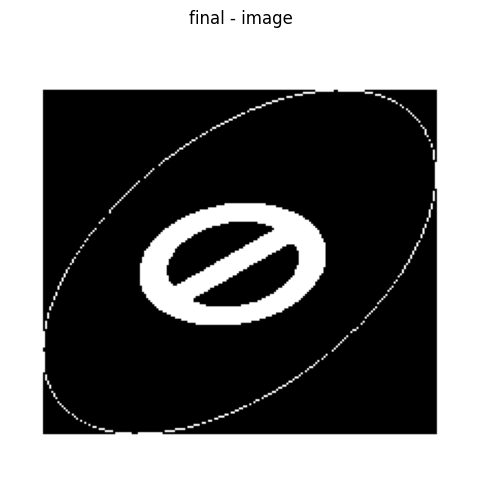

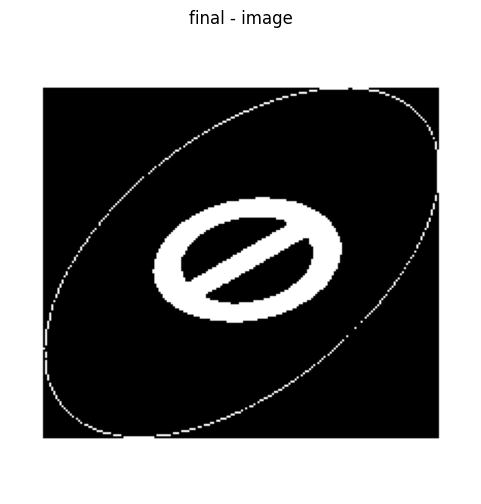

(209, 224, 224, 1) (209, 12)


In [38]:
X, y = load_data()
X = X.reshape(-1, img_size, img_size, 1) / 255.0  
y = tf.keras.utils.to_categorical(y, num_classes=len(categories)) 
print(X.shape,y.shape)

In [39]:
def show_image(img, title="Image", cmap=None):
    plt.figure(figsize=(6, 6))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

Step 5 : Spliting the data for training and testing

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

Step 6 : MobileNetV2 Pre-trained Model

In [45]:
model = Sequential([
    Input(shape=(img_size, img_size, 1)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D((2, 2)),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(12, activation='softmax')
])

Step 7 : Compiling the model

In [46]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

Step 8 : Training the model

In [47]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), 
                    epochs=100, batch_size=16, callbacks=[early_stop])

Epoch 1/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 3s 233ms/step - accuracy: 0.0753 - loss: 6.6551 - val_accuracy: 0.3095 - val_loss: 2.3531
Epoch 2/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.2973 - loss: 2.2817 - val_accuracy: 0.5000 - val_loss: 2.1841
Epoch 3/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 221ms/step - accuracy: 0.5915 - loss: 1.8069 - val_accuracy: 0.7619 - val_loss: 1.3219
Epoch 4/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.7161 - loss: 0.8782 - val_accuracy: 0.8095 - val_loss: 0.8648
Epoch 5/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.9226 - loss: 0.4087 - val_accuracy: 0.8095 - val_loss: 0.7573
Epoch 6/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 220ms/step - accuracy: 0.9203 - loss: 0.2510 - val_accuracy: 0.8810 - val_loss: 0.6633
Epoch 7/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 218ms/step - accuracy: 0.9741 - loss: 0.1289 - val_accuracy: 0.9048 - val_loss: 0.6985
Epoch 8/100
11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 217ms/step - accuracy: 0.9973 - loss: 0.0290 - val_accu

Step 9 : Evaluating the accuracy of the model

In [48]:
test_loss, test_acc = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_acc * 100:.2f}%")

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.8998 - loss: 0.5288
Test Accuracy: 88.10%


Step 10 : Save the Model